<a href="https://colab.research.google.com/github/Redital-Javier/python_cartera_inversion_gino/blob/main/Proyecto_Python_Cartera_Gino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# Paso 1: Instalar librerías del proyecto
!pip -q install --upgrade pip
!pip -q install yfinance pandas numpy matplotlib seaborn statsmodels pandas-datareader scikit-learn
!pip install PyPortfolioOpt


In [36]:
# Paso 2: Importar librerías y chequear versiones

import sys, platform, warnings, datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas_datareader.data as web
import os, datetime as dt
import math


from pypfopt import EfficientFrontier, risk_models, expected_returns, DiscreteAllocation

warnings.filterwarnings("ignore")

# Mostrar versiones
print("Python:", sys.version.split()[0])
print("OS:", platform.platform())
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", mpl.__version__)
print("seaborn:", sns.__version__)
print("yfinance:", yf.__version__)
print("statsmodels:", sm.__version__)

# Configuración de gráficos
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# Fechas del proyecto
START_DATE = "2022-01-01"
END_DATE   = dt.date.today().strftime("%Y-%m-%d")
print("Rango de análisis:", START_DATE, "→", END_DATE)

# Semilla para reproducibilidad
np.random.seed(42)

# Definir tickers
CEDEARS_BA = [
    "AAPL.BA","MSFT.BA","NVDA.BA","AMZN.BA","TSLA.BA","DIS.BA","GOOGL.BA",
    "MELI.BA","BRK.BA","KO.BA","JNJ.BA","PG.BA","PFE.BA","NKE.BA",
    "GLD.BA","EEM.BA","IEUR.BA","YPF.BA","PAMP.BA","VIST.BA"
]
CRYPTO = ["BTC-USD"]
BENCH  = ["SPY"]

print("CEDEARs:", len(CEDEARS_BA), "Crypto:", CRYPTO, "Benchmark:", BENCH)


Python: 3.12.12
OS: Linux-6.6.105+-x86_64-with-glibc2.35
pandas: 2.2.2
numpy: 2.0.2
matplotlib: 3.10.0
seaborn: 0.13.2
yfinance: 0.2.66
statsmodels: 0.14.5
Rango de análisis: 2022-01-01 → 2025-11-30
CEDEARs: 20 Crypto: ['BTC-USD'] Benchmark: ['SPY']


In [37]:
# Paso 3: Montar Google Drive y definir rutas del proyecto

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os

# Nombre exacto de tu carpeta en Drive
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/Proyecto Python Cartera Gino"

# Subcarpetas para organizar
DATA_DIR = os.path.join(BASE_DIR, "data")
FIGS_DIR = os.path.join(BASE_DIR, "figs")
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(FIGS_DIR, exist_ok=True)

print("Carpeta base:", BASE_DIR)
print("Carpeta data:", DATA_DIR)
print("Carpeta figs:", FIGS_DIR)


Mounted at /content/drive
Carpeta base: /content/drive/MyDrive/Colab Notebooks/Proyecto Python Cartera Gino
Carpeta data: /content/drive/MyDrive/Colab Notebooks/Proyecto Python Cartera Gino/data
Carpeta figs: /content/drive/MyDrive/Colab Notebooks/Proyecto Python Cartera Gino/figs


In [38]:
# Paso 4: Definir tickers y mostrar tabla (sin SPY)

tickers = [
    "AAPL","MSFT","NVDA","AMZN","TSLA","DIS","GOOGL",
    "MELI","BRK-B","KO","JNJ","PG","PFE","NKE",
    "GLD","EEM","IEUR","YPF","PAM","VIST",
    "UNH",
    "BTC-USD","SPY"
]

# Excluir SPY
tickers_sin_spy = [t for t in tickers if t != "SPY"]

# Ordenar
tickers_sorted = sorted(tickers_sin_spy)

# Crear DataFrame
df_tickers = pd.DataFrame({"Ticker": tickers_sorted})
df_tickers.index = df_tickers.index + 1
df_tickers.index.name = "N°"

# Mostrar con estilo oscuro
display(
    df_tickers.style
    .set_caption("Listado de Tickers del Portafolio (Orden Alfabético, sin SPY)")
    .set_table_styles([
        {"selector": "th", "props": [
            ("background-color", "#1E1E1E"),
            ("color", "white"),
            ("padding", "6px 10px"),
            ("font-size", "12px"),
            ("border", "1px solid #444"),
            ("text-align", "center")
        ]},
        {"selector": "td", "props": [
            ("background-color", "#2B2B2B"),
            ("color", "#E0E0E0"),
            ("padding", "6px 10px"),
            ("font-size", "12px"),
            ("border", "1px solid #444"),
            ("text-align", "center")
        ]},
        {"selector": "caption", "props": [
            ("caption-side", "top"),
            ("font-size", "14px"),
            ("font-weight", "bold"),
            ("color", "#E0E0E0"),
            ("text-align", "center"),
            ("padding", "6px")
        ]}
    ])
)



In [39]:
# Paso 5: Descargar precios ajustados (2022 → hoy)

raw = yf.download(
    tickers,
    start="2022-01-01",
    end=dt.date.today().strftime("%Y-%m-%d"),
    auto_adjust=True,
    progress=False
)

# Selección de precios de cierre
if isinstance(raw.columns, pd.MultiIndex):
    data = raw.xs('Close', level=0, axis=1).copy()
else:
    data = raw['Close'].copy()

# Eliminación de filas con faltantes
data = data.dropna()

# Vista rápida
print("Dimensiones:", data.shape)
data.head()




Dimensiones: (981, 23)


Ticker            AAPL        AMZN       BRK-B       BTC-USD         DIS  \
Date                                                                       
2022-01-03  178.270340  170.404495  300.790009  46458.117188  154.189529   
2022-01-04  176.007782  167.522003  308.529999  45897.574219  153.176422   
2022-01-05  171.326019  164.356995  309.920013  43569.003906  152.645294   
2022-01-06  168.466019  163.253998  313.220001  43160.929688  154.327240   
2022-01-07  168.632492  162.554001  319.779999  41557.902344  155.242004   

Ticker            EEM         GLD       GOOGL       IEUR         JNJ  ...  \
Date                                                                  ...   
2022-01-03  45.263573  168.330002  143.998322  52.333141  152.576859  ...   
2022-01-04  45.107178  169.570007  143.410385  52.449081  152.167725  ...   
2022-01-05  44.371185  169.059998  136.831268  52.012081  153.181717  ...   
2022-01-06  44.573582  166.990005  136.803955  51.798042  152.656937  ...   
2022-01-07  44.978378  167.750000  136.078461  52.074509  154.720444  ...   

Ticker             NKE       NVDA        PAM        PFE          PG  \
Date                                                                  
2022-01-03  155.485046  30.064440  20.049999  46.125652  147.359726   
2022-01-04  157.109131  29.235003  19.980000  44.399490  147.875397   
2022-01-05  153.200027  27.552166  18.959999  45.295132  148.544830   
2022-01-06  152.057556  28.125086  18.750000  44.651897  147.296478   
2022-01-07  148.214554  27.195837  19.160000  45.368420  147.215042   

Ticker             SPY        TSLA         UNH  VIST   YPF  
Date                                                        
2022-01-03  453.210419  399.926666  472.636353  5.36  4.04  
2022-01-04  453.058594  383.196655  461.928040  5.77  4.16  
2022-01-05  444.358917  362.706665  460.789459  5.43  3.99  
2022-01-06  443.941498  354.899994  441.932098  5.54  3.95  
2022-01-07  442.186371  342.320007  431.534332  5.71  4.03  

[5 rows x 23 columns]

In [40]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")


Dimensiones base100: (981, 23)


Ticker            AAPL        AMZN       BRK-B     BTC-USD         DIS  \
Date                                                                     
2022-01-03  100.000000  100.000000  100.000000  100.000000  100.000000   
2022-01-04   98.730828   98.308441  102.573221   98.793444   99.342947   
2022-01-05   96.104612   96.451091  103.035342   93.781252   98.998482   
2022-01-06   94.500307   95.803809  104.132449   92.902882  100.089313   
2022-01-07   94.593690   95.393024  106.313371   89.452403  100.682585   

Ticker             EEM         GLD       GOOGL        IEUR         JNJ  ...  \
Date                                                                    ...   
2022-01-03  100.000000  100.000000  100.000000  100.000000  100.000000  ...   
2022-01-04   99.654479  100.736652   99.591706  100.221542   99.731851  ...   
2022-01-05   98.028465  100.433669   95.022822   99.386507  100.396429  ...   
2022-01-06   98.475615   99.203947   95.003854   98.977514  100.052484  ...   
2022-01-07   99.369925   99.655438   94.500033   99.505796  101.404922  ...   

Ticker             NKE        NVDA         PAM         PFE          PG  \
Date                                                                     
2022-01-03  100.000000  100.000000  100.000000  100.000000  100.000000   
2022-01-04  101.044528   97.241135   99.650874   96.257696  100.349940   
2022-01-05   98.530393   91.643703   94.563590   98.199439  100.804225   
2022-01-06   97.795614   93.549343   93.516213   96.804913   99.957079   
2022-01-07   95.323992   90.458486   95.561100   98.358326   99.901816   

Ticker             SPY        TSLA         UNH        VIST         YPF  
Date                                                                    
2022-01-03  100.000000  100.000000  100.000000  100.000000  100.000000  
2022-01-04   99.966500   95.816730   97.734344  107.649251  102.970294  
2022-01-05   98.046933   90.693293   97.493444  101.305964   98.762377  
2022-01-06   97.954831   88.741268   93.503620  103.358206   97.772279  
2022-01-07   97.567565   85.595694   91.303669  106.529849   99.752481  

[5 rows x 23 columns]

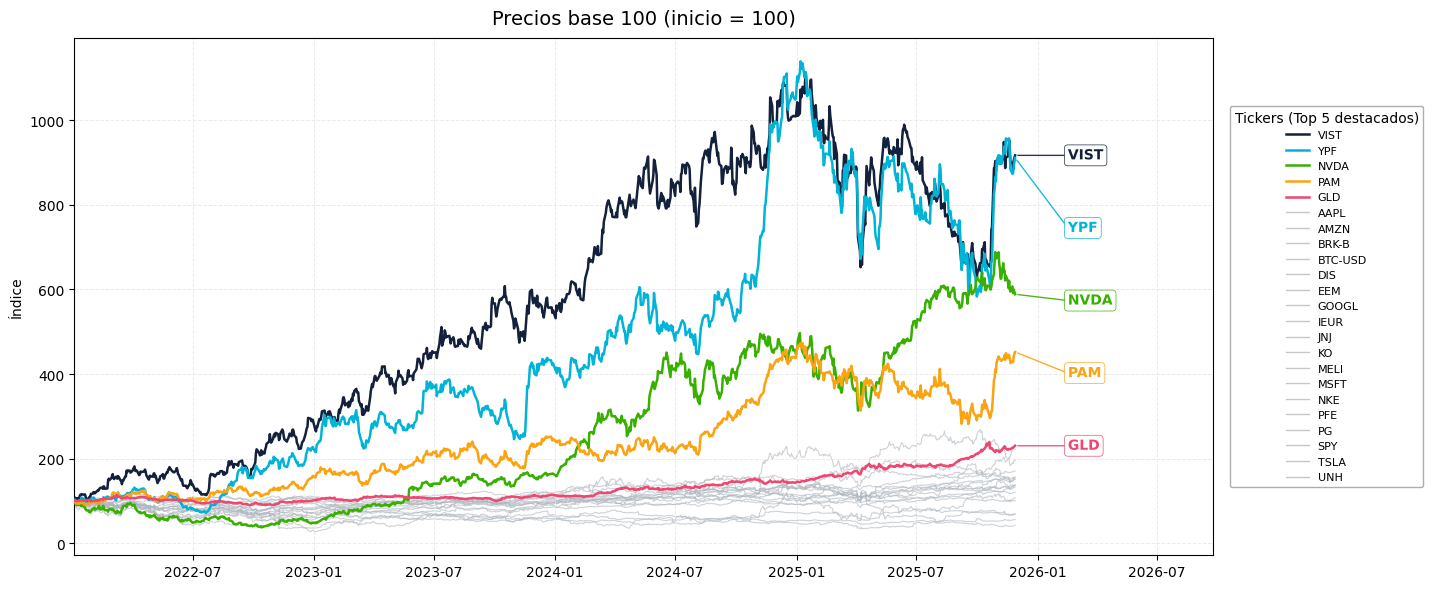

In [41]:
# Paso 6: Precios base 100
from matplotlib import patheffects as pe
from cycler import cycler

# Cálculo base 100
base100 = data.div(data.iloc[0]).mul(100)

print("Dimensiones base100:", base100.shape)
display(base100.head())

# Últimos valores y top 5
last_values = base100.iloc[-1].sort_values(ascending=False)
top_tickers = last_values.head(5).index.tolist()

# Gráfico
with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(17, 6))
    ax.set_facecolor("white")
    fig.patch.set_facecolor("white")

    # Líneas grises para los no destacados
    ax.plot(base100.index, base100.values, color="#adb5bd",
            linewidth=0.8, alpha=0.6, zorder=1)

    # Colores para los top 5 (dinámicos, sin hardcodear tickers)
    paleta_top5 = ["#14213d", "#00b4d8", "#38b000", "#fca311", "#ef476f"]
    color_map = dict(zip(top_tickers, paleta_top5))

    # Top 5 destacados
    for t in top_tickers:
        ax.plot(base100.index, base100[t],
                color=color_map.get(t, "#333333"),
                linewidth=1.8, zorder=3, label=t)

    # Coordenadas para etiquetas
    y_last = {t: float(base100[t].iloc[-1]) for t in top_tickers}
    ordered = sorted(top_tickers, key=lambda k: y_last[k])
    ymin, ymax = ax.get_ylim()
    pad = (ymax - ymin) * 0.05
    y_targets = np.linspace(
        max(ymin + pad, min(y_last.values())),
        min(ymax - pad, max(y_last.values())),
        num=len(ordered)
    )
    last_x = base100.index[-1]
    x_text = last_x + pd.Timedelta(days=80)

    # Etiquetas de color con líneas guía
    for t, y_tgt in zip(ordered, y_targets):
        c = color_map.get(t, "#000000")
        ax.annotate(
            "",
            xy=(x_text, y_tgt),
            xytext=(last_x, y_last[t]),
            arrowprops=dict(arrowstyle="-", color=c, lw=1, alpha=0.9),
            zorder=4
        )
        ax.text(
            x_text, y_tgt, f"{t}",
            va="center", ha="left",
            fontsize=10, color=c, fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.25",
                      fc="white", ec=c, lw=0.5, alpha=0.95),
            path_effects=[pe.withStroke(linewidth=1, foreground="white")],
            zorder=5
        )

    # Ejes y estilo general
    ax.set_title("Precios base 100 (inicio = 100)",
                 fontsize=14, color="black", pad=10)
    ax.set_ylabel("Índice", color="black")
    ax.tick_params(colors="black")
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_color("black")
    ax.grid(True, color="#e6e6e6", linestyle="--",
            linewidth=0.7, alpha=0.8)
    ax.set_xlim(base100.index[0],
                base100.index[-1] + pd.Timedelta(days=300))

    # Leyenda lateral
    handles, labels = ax.get_legend_handles_labels()
    otros_tickers = [t for t in base100.columns if t not in top_tickers]
    for t in otros_tickers:
        h, = ax.plot([], [], color="#c7c7c7", lw=1, label=t)
        handles.append(h)
        labels.append(t)

    leg = ax.legend(
        handles, labels,
        title="Tickers (Top 5 destacados)",
        frameon=True, facecolor="white", edgecolor="#999",
        fontsize=8, ncol=1,
        loc='center left', bbox_to_anchor=(1.01, 0.5)
    )

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()



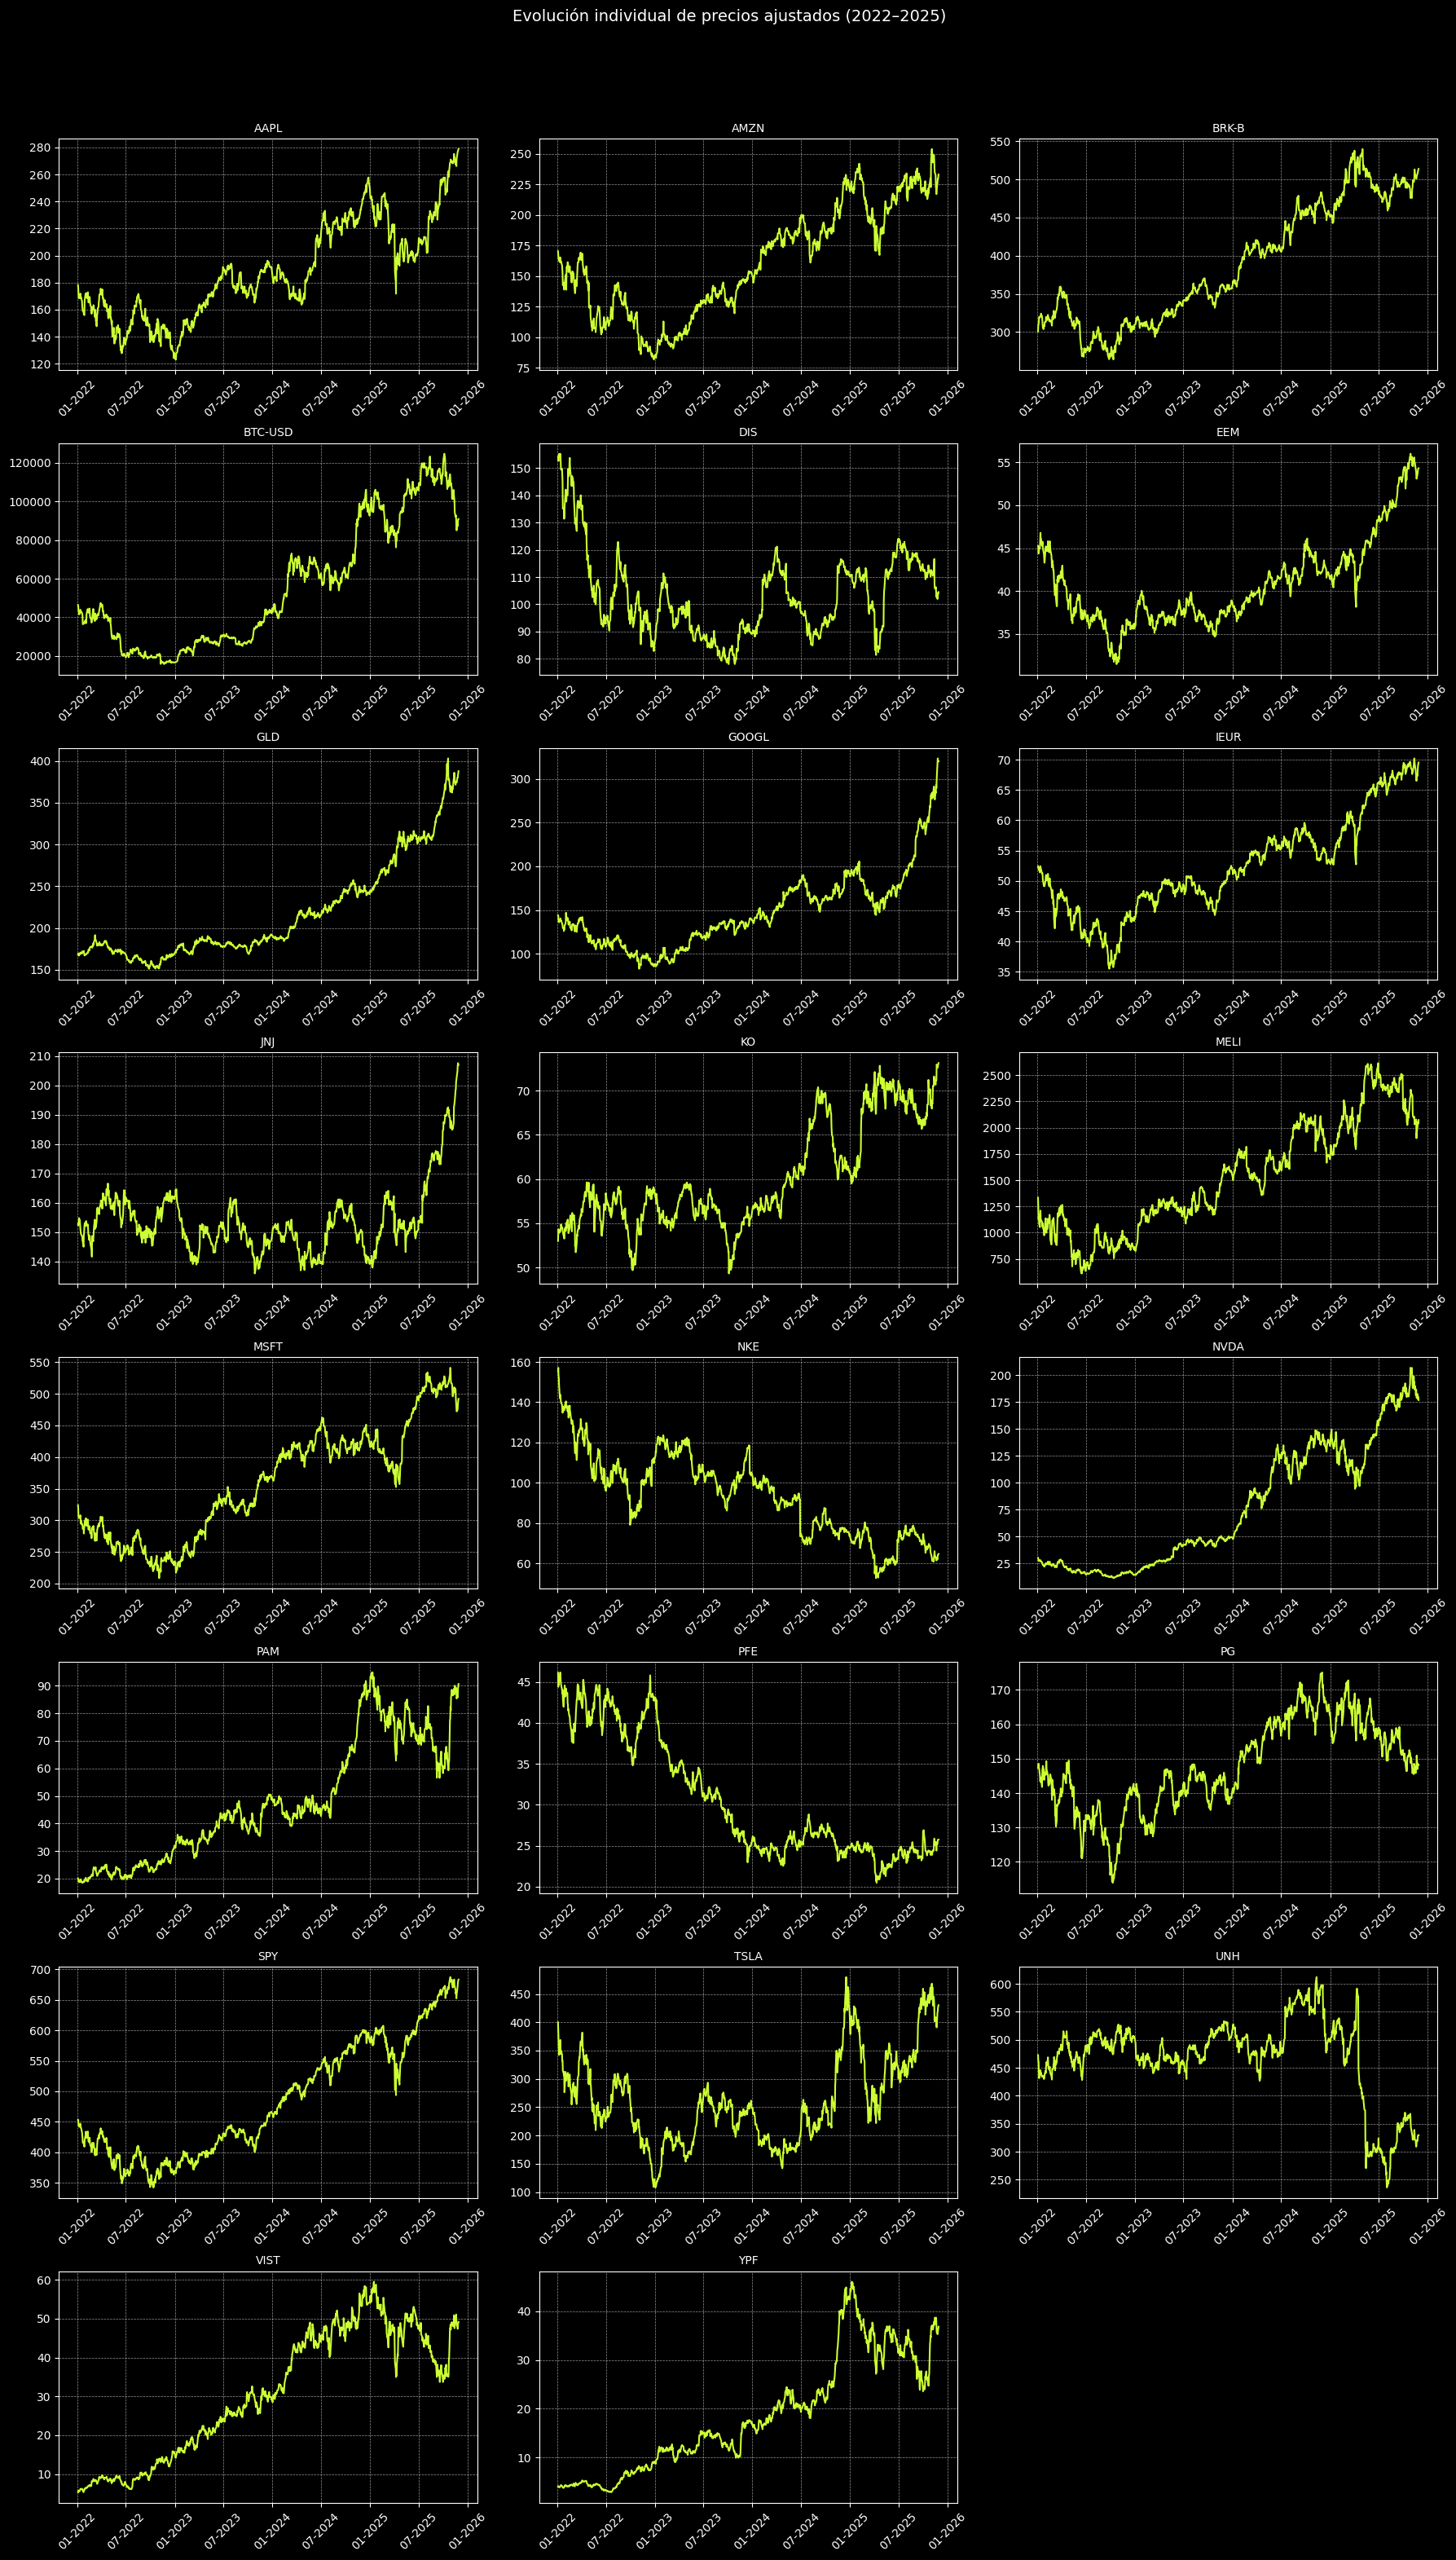

In [42]:
# Paso 7: Gráficos individuales de precios ajustados

import matplotlib.dates as mdates

n = len(data.columns)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 4*rows), sharex=True)
axes = axes.flatten()

for i, ticker in enumerate(data.columns):
    axes[i].plot(data.index, data[ticker], lw=1.5, color="#ccff33")
    axes[i].set_title(ticker, fontsize=10)
    axes[i].tick_params(axis='x', labelbottom=True)
    axes[i].grid(True, color="#d3d3d3", linestyle="--", linewidth=0.5, alpha=0.7)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

date_format = mdates.DateFormatter('%m-%Y')
for ax in axes:
    ax.xaxis.set_major_formatter(date_format)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle("Evolución individual de precios ajustados (2022–2025)", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()



In [43]:
# Paso 8: Retornos diarios
ret_diarios = data.pct_change().dropna()
print("Dimensiones retornos diarios:", ret_diarios.shape)
display(ret_diarios.head())


Dimensiones retornos diarios: (980, 23)


Ticker          AAPL      AMZN     BRK-B   BTC-USD       DIS       EEM  \
Date                                                                     
2022-01-04 -0.012692 -0.016916  0.025732 -0.012066 -0.006571 -0.003455   
2022-01-05 -0.026600 -0.018893  0.004505 -0.050734 -0.003467 -0.016317   
2022-01-06 -0.016693 -0.006711  0.010648 -0.009366  0.011019  0.004561   
2022-01-07  0.000988 -0.004288  0.020944 -0.037141  0.005927  0.009082   
2022-01-10  0.000116 -0.006570 -0.002658  0.006337 -0.007793  0.000000   

Ticker           GLD     GOOGL      IEUR       JNJ  ...       NKE      NVDA  \
Date                                                ...                       
2022-01-04  0.007367 -0.004083  0.002215 -0.002681  ...  0.010445 -0.027589   
2022-01-05 -0.003008 -0.045876 -0.008332  0.006664  ... -0.024881 -0.057562   
2022-01-06 -0.012244 -0.000200 -0.004115 -0.003426  ... -0.007457  0.020794   
2022-01-07  0.004551 -0.005303  0.005337  0.013517  ... -0.025273 -0.033040   
2022-01-10  0.003040  0.012061 -0.012845 -0.004944  ... -0.041601  0.005615   

Ticker           PAM       PFE        PG       SPY      TSLA       UNH  \
Date                                                                     
2022-01-04 -0.003491 -0.037423  0.003499 -0.000335 -0.041833 -0.022657   
2022-01-05 -0.051051  0.020172  0.004527 -0.019202 -0.053471 -0.002465   
2022-01-06 -0.011076 -0.014201 -0.008404 -0.000939 -0.021523 -0.040924   
2022-01-07  0.021867  0.016047 -0.000553 -0.003954 -0.035447 -0.023528   
2022-01-10 -0.025574  0.009332 -0.013641 -0.001244  0.030342  0.013956   

Ticker          VIST       YPF  
Date                            
2022-01-04  0.076493  0.029703  
2022-01-05 -0.058926 -0.040865  
2022-01-06  0.020258 -0.010025  
2022-01-07  0.030686  0.020253  
2022-01-10 -0.010508 -0.029777  

[5 rows x 23 columns]

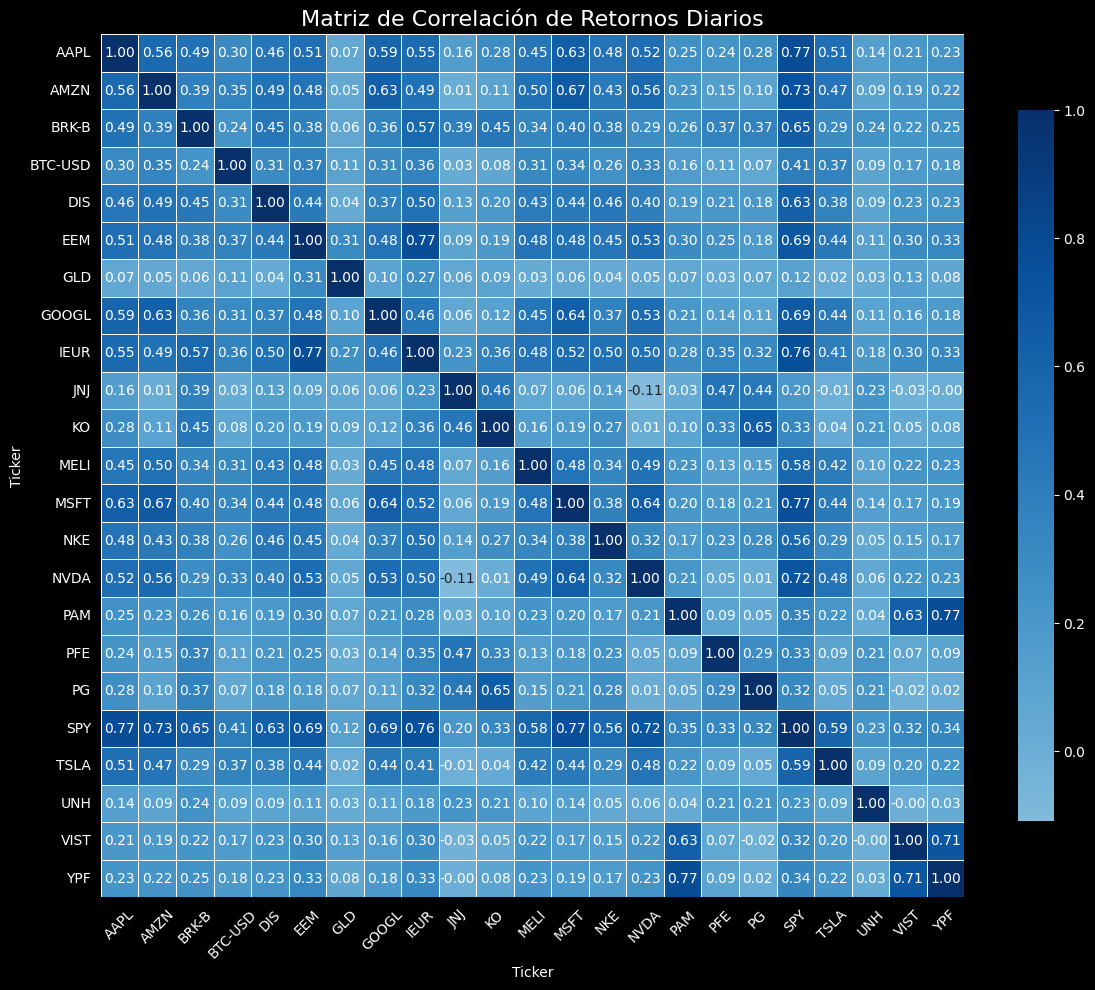

In [44]:
# Paso 9: Matriz de correlaciones
correlacion = ret_diarios.corr()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    correlacion,
    annot=True,
    cmap='Blues',
    center=0,
    linewidths=0.7,
    fmt=".2f",
    square=True,
    cbar_kws={"shrink": 0.8}
)

ax.grid(False)
ax.tick_params(left=False, bottom=False)

plt.title('Matriz de Correlación de Retornos Diarios', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


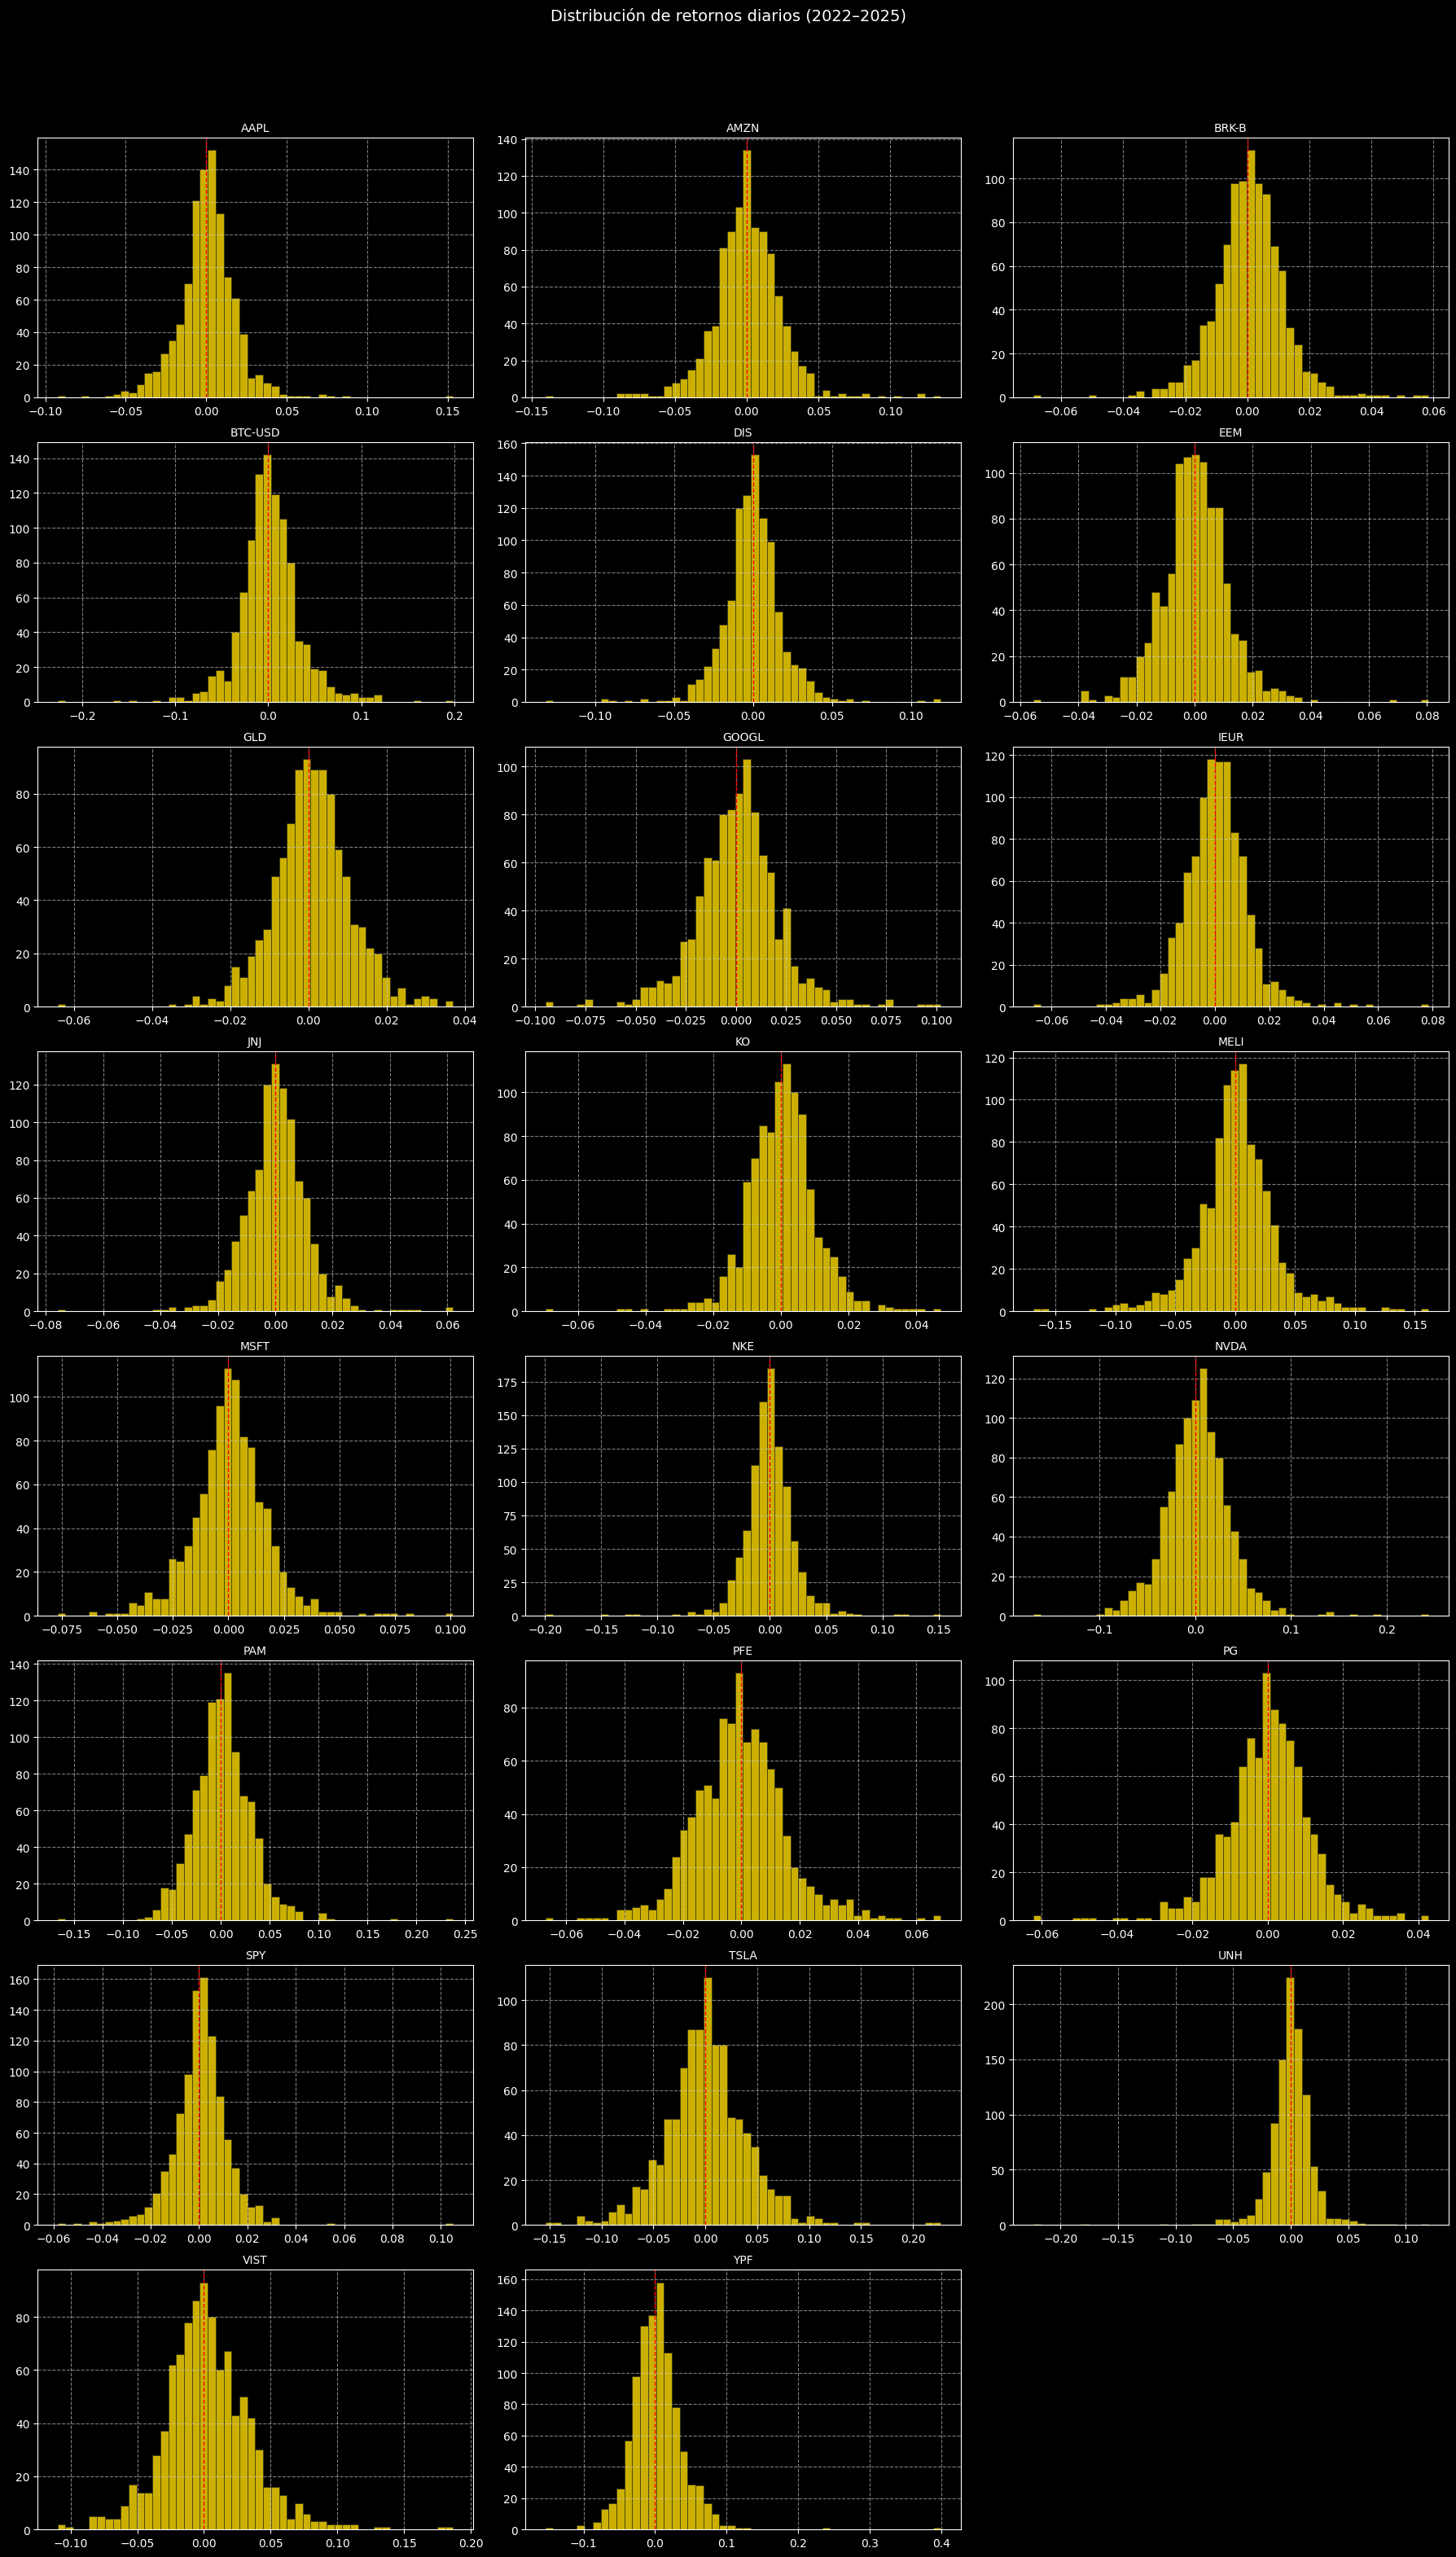

In [45]:
# Paso 10: Histogramas de retornos diarios

n = len(ret_diarios.columns)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, 4*rows))
axes = axes.flatten()

for i, ticker in enumerate(ret_diarios.columns):
    axes[i].hist(
        ret_diarios[ticker],
        bins=50,
        alpha=0.8,
        color="#ffdd00",
        edgecolor="#222222",
        linewidth=0.5
    )
    # Línea vertical en 0%
    axes[i].axvline(0, color="red", linestyle="--", linewidth=1)

    axes[i].set_title(ticker, fontsize=10)
    axes[i].grid(True, linestyle="--", color="#d3d3d3", alpha=0.6)

# Eliminar ejes vacíos
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribución de retornos diarios (2022–2025)", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()



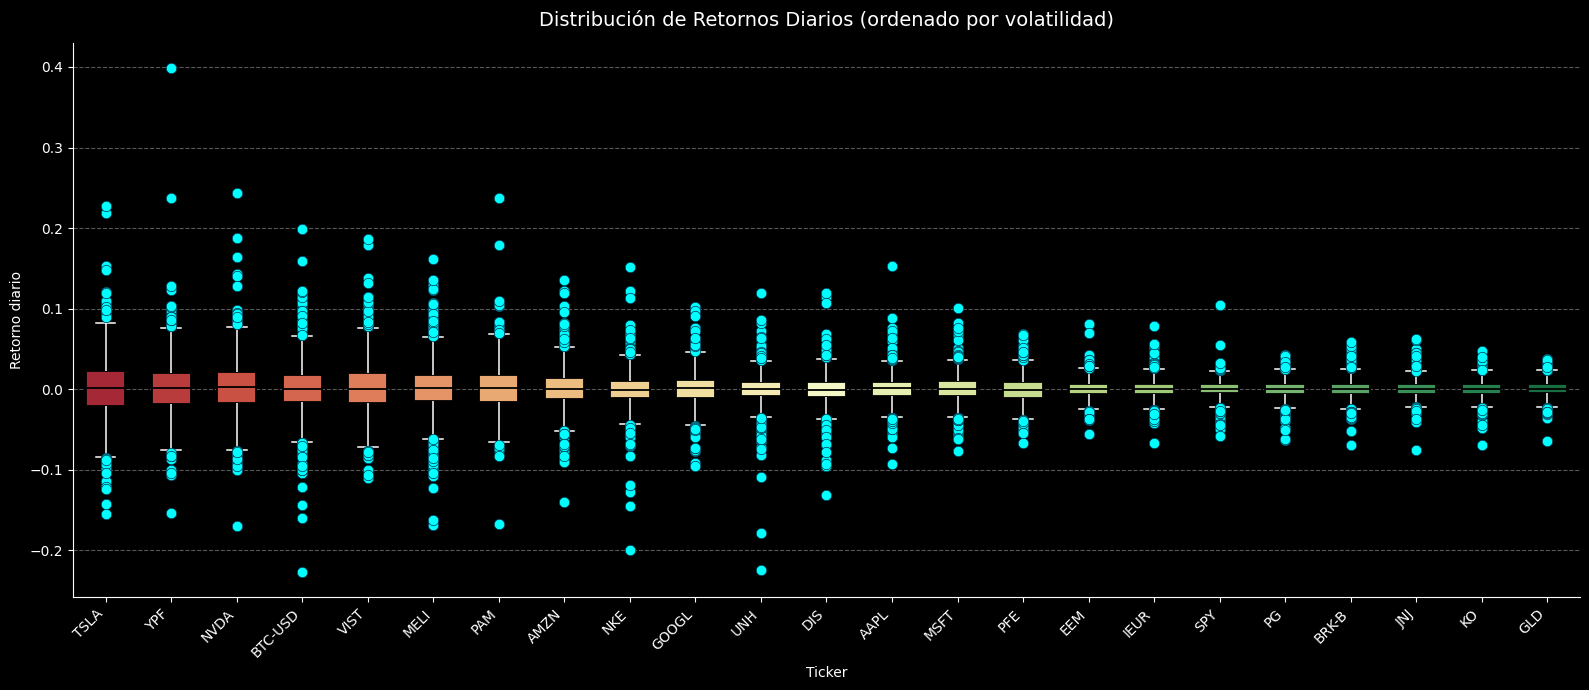

In [46]:
# Paso 11: Boxplots comparativos de retornos diarios

# Ordenar tickers por volatilidad (descendente)
order = ret_diarios.std().sort_values(ascending=False).index

# Paleta de color (de rojo a verde)
paleta = sns.color_palette("RdYlGn", n_colors=len(order))

plt.figure(figsize=(16, 7))

# Configuración de los outliers con contorno
flier_props = dict(
    marker='o',
    markerfacecolor='#00FFFF',   # relleno
    markeredgecolor='#00334d',   # contorno
    markeredgewidth=0.5,         # grosor del contorno
    markersize=7.5,
    alpha=1
)

# Propiedades visuales adicionales
box_props = dict(edgecolor='black', linewidth=1.3)     # borde de cada caja
median_props = dict(color='black', linewidth=1.3)      # línea mediana
whisker_props = dict(color='white', linewidth=1.1)     # bigotes visibles
cap_props = dict(color='white', linewidth=1.1)         # extremos de los bigotes

# Crear el boxplot
sns.boxplot(
    data=ret_diarios[order],
    palette=paleta,
    showfliers=True,
    linewidth=1.3,
    width=0.6,
    flierprops=flier_props,
    boxprops=box_props,
    medianprops=median_props,
    whiskerprops=whisker_props,
    capprops=cap_props
)

sns.despine()
plt.title("Distribución de Retornos Diarios (ordenado por volatilidad)", fontsize=14, pad=12)
plt.ylabel("Retorno diario")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.35)
plt.tight_layout()
plt.show()


In [47]:
# Paso 12: Estadísticas descriptivas

# Básicas (diarias)
stats = ret_diarios.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T

# Métricas adicionales
stats["skew"] = ret_diarios.skew()
stats["kurt"] = ret_diarios.kurt()

# Anualizadas
stats["mean_ann"] = ret_diarios.mean() * 252
stats["vol_ann"]  = ret_diarios.std()  * np.sqrt(252)

# Ordenar por volatilidad anualizada
stats = stats.sort_values("vol_ann", ascending=False)

display(stats.round(4))


count    mean     std     min      1%      5%     25%     50%  \
Ticker                                                                   
TSLA     980.0  0.0008  0.0392 -0.1543 -0.0974 -0.0615 -0.0207  0.0010   
YPF      980.0  0.0029  0.0360 -0.1534 -0.0731 -0.0489 -0.0182  0.0014   
NVDA     980.0  0.0024  0.0342 -0.1697 -0.0781 -0.0522 -0.0176  0.0030   
BTC-USD  980.0  0.0012  0.0335 -0.2268 -0.0854 -0.0505 -0.0159  0.0004   
VIST     980.0  0.0028  0.0330 -0.1098 -0.0781 -0.0493 -0.0170  0.0008   
MELI     980.0  0.0010  0.0324 -0.1688 -0.0925 -0.0493 -0.0143  0.0011   
PAM      980.0  0.0020  0.0301 -0.1670 -0.0620 -0.0433 -0.0160  0.0011   
AMZN     980.0  0.0006  0.0238 -0.1405 -0.0613 -0.0358 -0.0123  0.0004   
NKE      980.0 -0.0006  0.0227 -0.1998 -0.0582 -0.0318 -0.0114 -0.0006   
GOOGL    980.0  0.0010  0.0207 -0.0951 -0.0497 -0.0313 -0.0109  0.0014   
UNH      980.0 -0.0002  0.0201 -0.2238 -0.0607 -0.0264 -0.0083  0.0006   
DIS      980.0 -0.0002  0.0191 -0.1316 -0.0505 -0.0286 -0.0093 -0.0003   
AAPL     980.0  0.0006  0.0181 -0.0925 -0.0481 -0.0291 -0.0082  0.0010   
MSFT     980.0  0.0006  0.0170 -0.0772 -0.0423 -0.0268 -0.0080  0.0007   
PFE      980.0 -0.0005  0.0157 -0.0672 -0.0399 -0.0237 -0.0102 -0.0008   
EEM      980.0  0.0003  0.0117 -0.0556 -0.0285 -0.0182 -0.0060  0.0005   
IEUR     980.0  0.0004  0.0115 -0.0668 -0.0304 -0.0169 -0.0062  0.0007   
SPY      980.0  0.0005  0.0114 -0.0585 -0.0322 -0.0171 -0.0051  0.0006   
PG       980.0  0.0001  0.0113 -0.0623 -0.0277 -0.0176 -0.0058  0.0004   
BRK-B    980.0  0.0006  0.0112 -0.0691 -0.0282 -0.0169 -0.0055  0.0007   
JNJ      980.0  0.0004  0.0109 -0.0759 -0.0262 -0.0161 -0.0053  0.0004   
KO       980.0  0.0004  0.0102 -0.0696 -0.0256 -0.0151 -0.0057  0.0006   
GLD      980.0  0.0009  0.0101 -0.0643 -0.0241 -0.0155 -0.0050  0.0008   

            75%     95%     99%     max    skew     kurt  mean_ann  vol_ann  
Ticker                                                                       
TSLA     0.0221  0.0622  0.1011  0.2269  0.2911   2.8194    0.2116   0.6227  
YPF      0.0203  0.0630  0.0895  0.3989  1.7219  16.6787    0.7268   0.5722  
NVDA     0.0216  0.0529  0.0898  0.2437  0.5402   4.6781    0.6021   0.5432  
BTC-USD  0.0175  0.0555  0.0979  0.1987  0.0349   5.4983    0.3139   0.5311  
VIST     0.0208  0.0567  0.0979  0.1866  0.5641   2.6270    0.7055   0.5232  
MELI     0.0176  0.0513  0.0918  0.1616 -0.0411   3.5359    0.2459   0.5141  
PAM      0.0182  0.0477  0.0781  0.2375  0.7165   5.9076    0.5011   0.4782  
AMZN     0.0139  0.0358  0.0653  0.1354  0.1639   4.6563    0.1517   0.3771  
NKE      0.0105  0.0317  0.0602  0.1519 -0.5725  12.5371   -0.1597   0.3608  
GOOGL    0.0120  0.0318  0.0563  0.1022  0.0850   2.9255    0.2594   0.3285  
UNH      0.0092  0.0250  0.0522  0.1198 -2.1078  24.9787   -0.0400   0.3189  
DIS      0.0095  0.0294  0.0449  0.1189 -0.0458   7.7154   -0.0540   0.3035  
AAPL     0.0096  0.0262  0.0455  0.1533  0.5422   7.2587    0.1562   0.2879  
MSFT     0.0098  0.0255  0.0428  0.1013  0.2497   3.3064    0.1437   0.2695  
PFE      0.0085  0.0262  0.0426  0.0683  0.2464   1.6661   -0.1190   0.2491  
EEM      0.0070  0.0181  0.0299  0.0805  0.4090   4.2452    0.0640   0.1853  
IEUR     0.0065  0.0171  0.0294  0.0785  0.2445   4.7634    0.0898   0.1832  
SPY      0.0064  0.0178  0.0264  0.1050  0.3614   9.0120    0.1221   0.1817  
PG       0.0066  0.0166  0.0284  0.0427 -0.4853   3.2657    0.0175   0.1790  
BRK-B    0.0070  0.0172  0.0292  0.0584 -0.0146   3.8880    0.1535   0.1779  
JNJ      0.0059  0.0161  0.0286  0.0619  0.1133   5.5538    0.0932   0.1724  
KO       0.0060  0.0164  0.0265  0.0473 -0.2652   4.1147    0.0959   0.1617  
GLD      0.0066  0.0173  0.0275  0.0370 -0.1919   2.3598    0.2275   0.1600

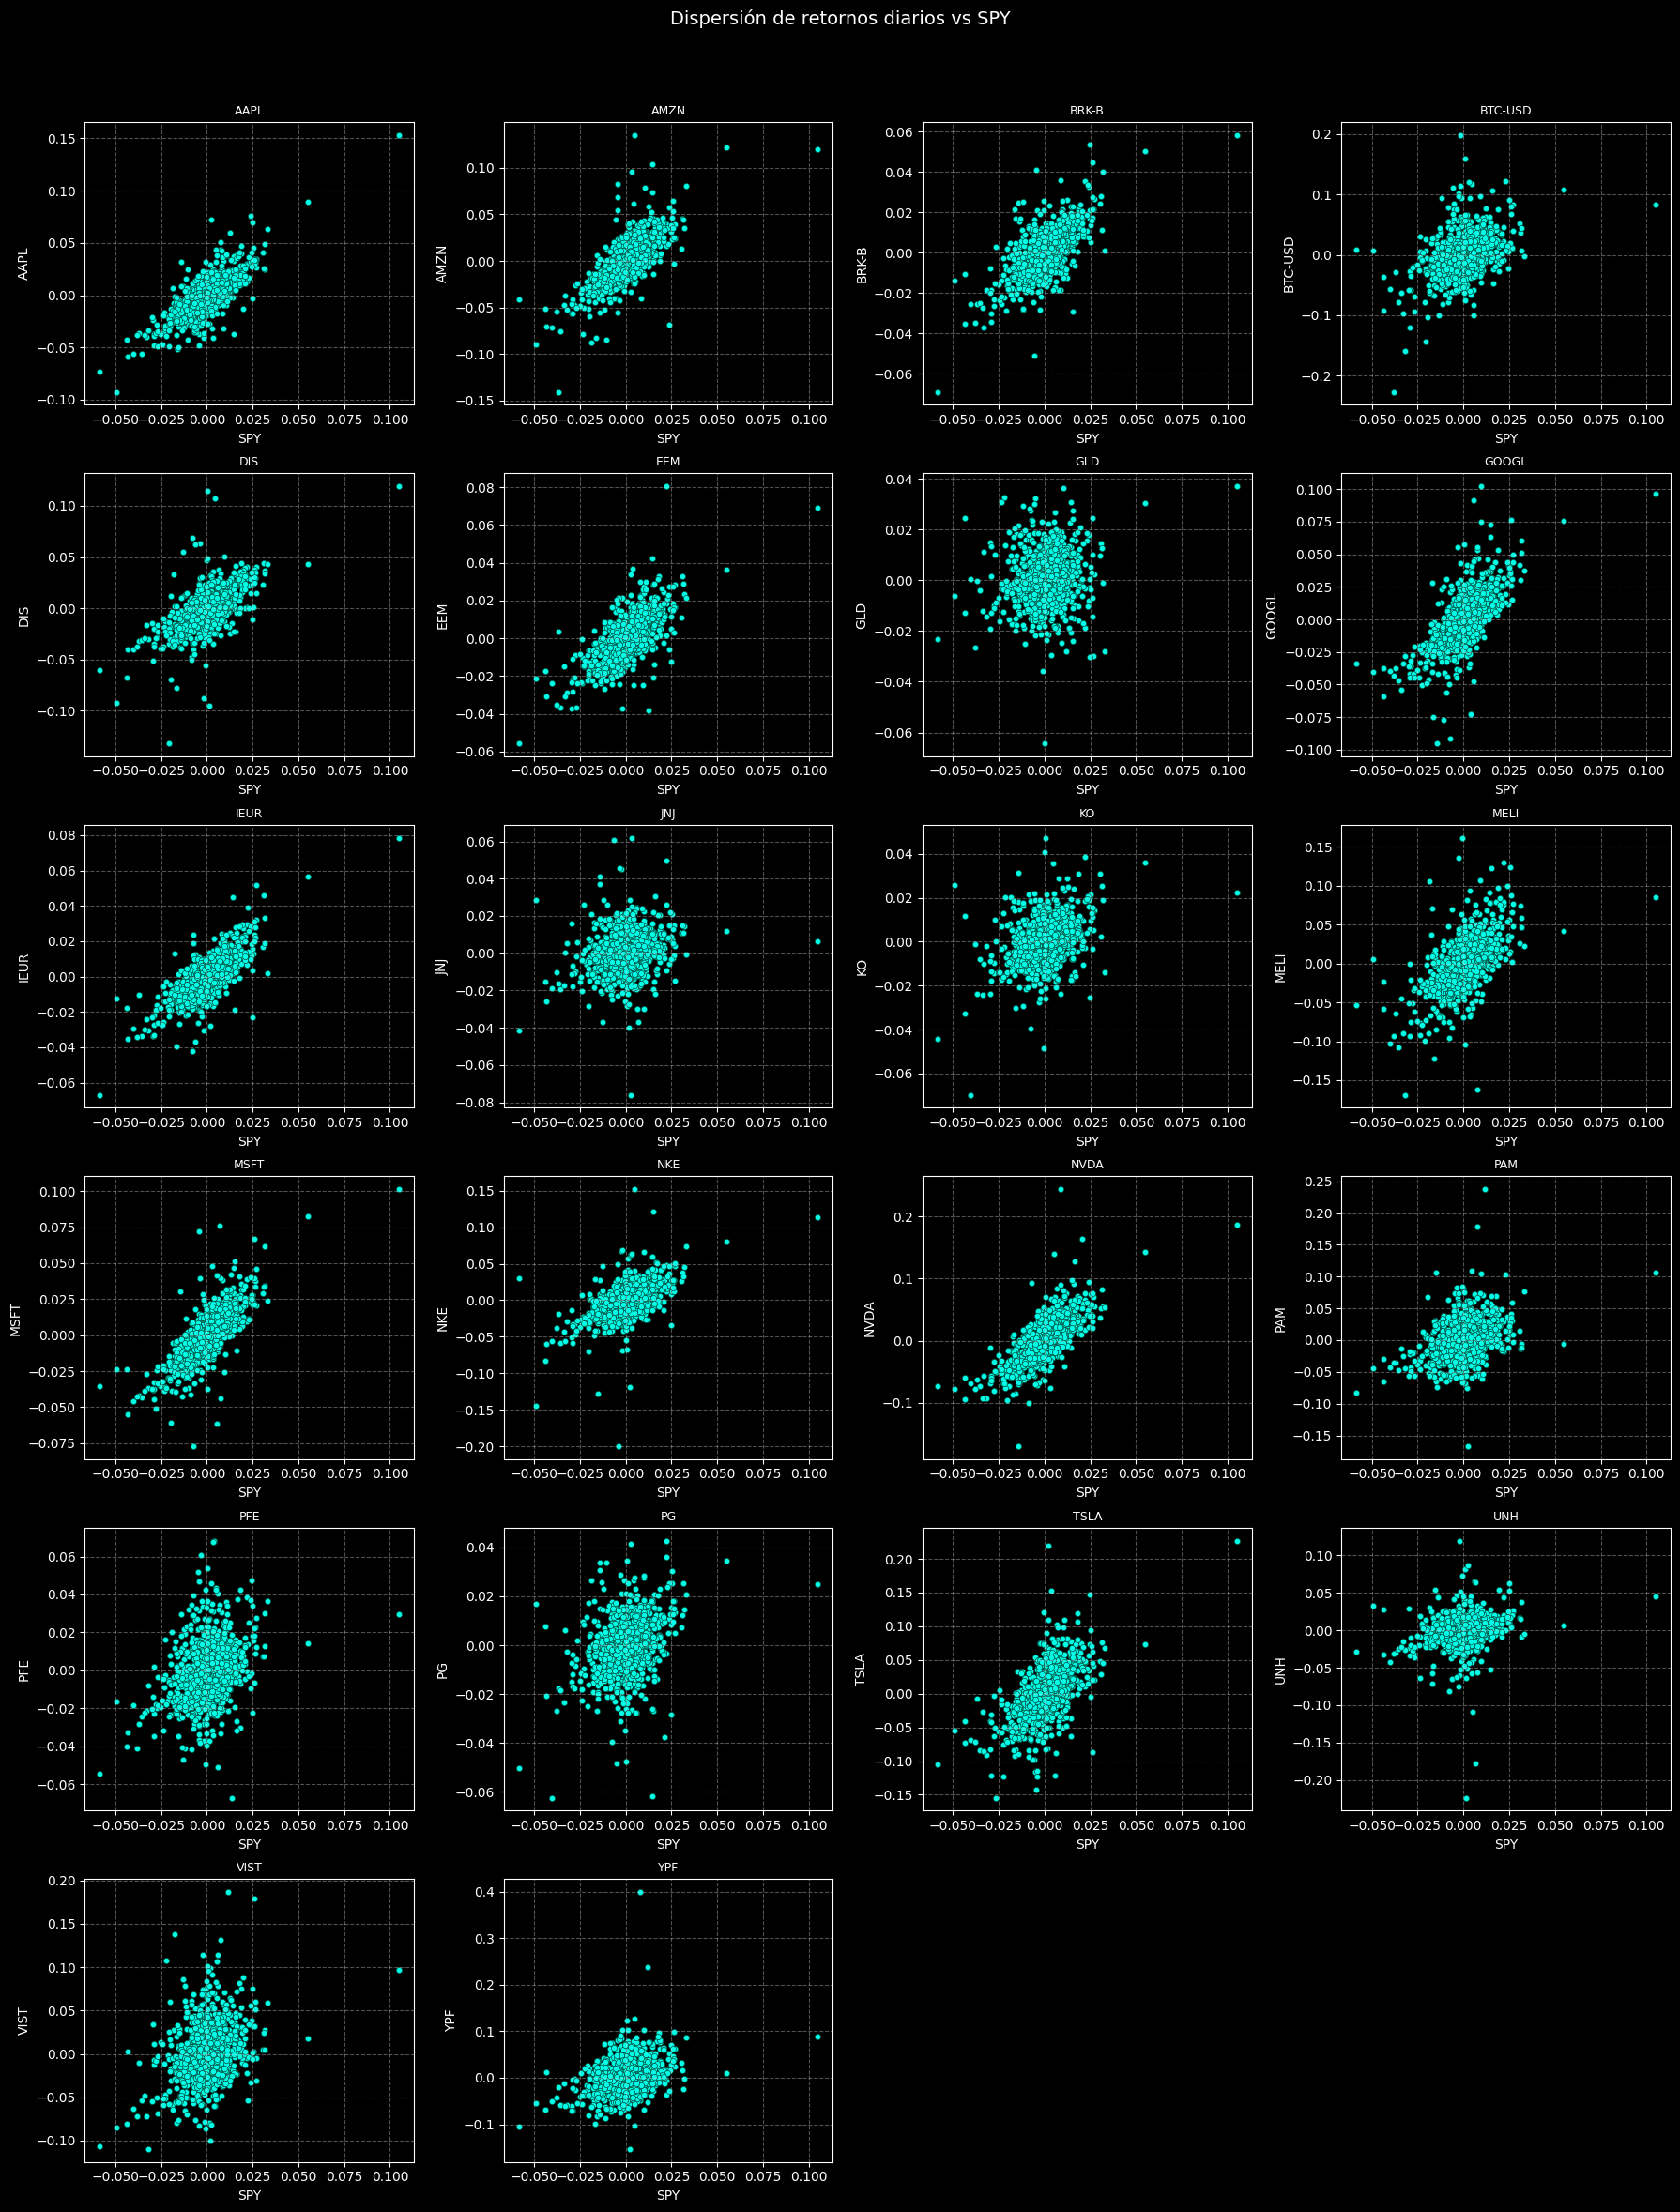

In [48]:
# Paso 13: Diagramas de dispersión de cada activo vs SPY

tickers = [t for t in ret_diarios.columns if t != "SPY"]

n = len(tickers)
cols = 4
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, 4*rows))
axes = axes.flatten()

for i, t in enumerate(tickers):
    ax = axes[i]
    ax.scatter(
        ret_diarios["SPY"],
        ret_diarios[t],
        s=20,                      # tamaño de los puntos
        alpha=1,                 # transparencia
        facecolors="#00ffe7",      # color de relleno
        edgecolors="#004d40",      # contorno oscuro
        linewidths=0.5             # grosor del contorno
    )
    ax.set_title(t, fontsize=9)
    ax.set_xlabel("SPY")
    ax.set_ylabel(t)
    ax.grid(True, color="#cccccc", linestyle="--", alpha=0.4)

# Quitar subplots vacíos
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Dispersión de retornos diarios vs SPY", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


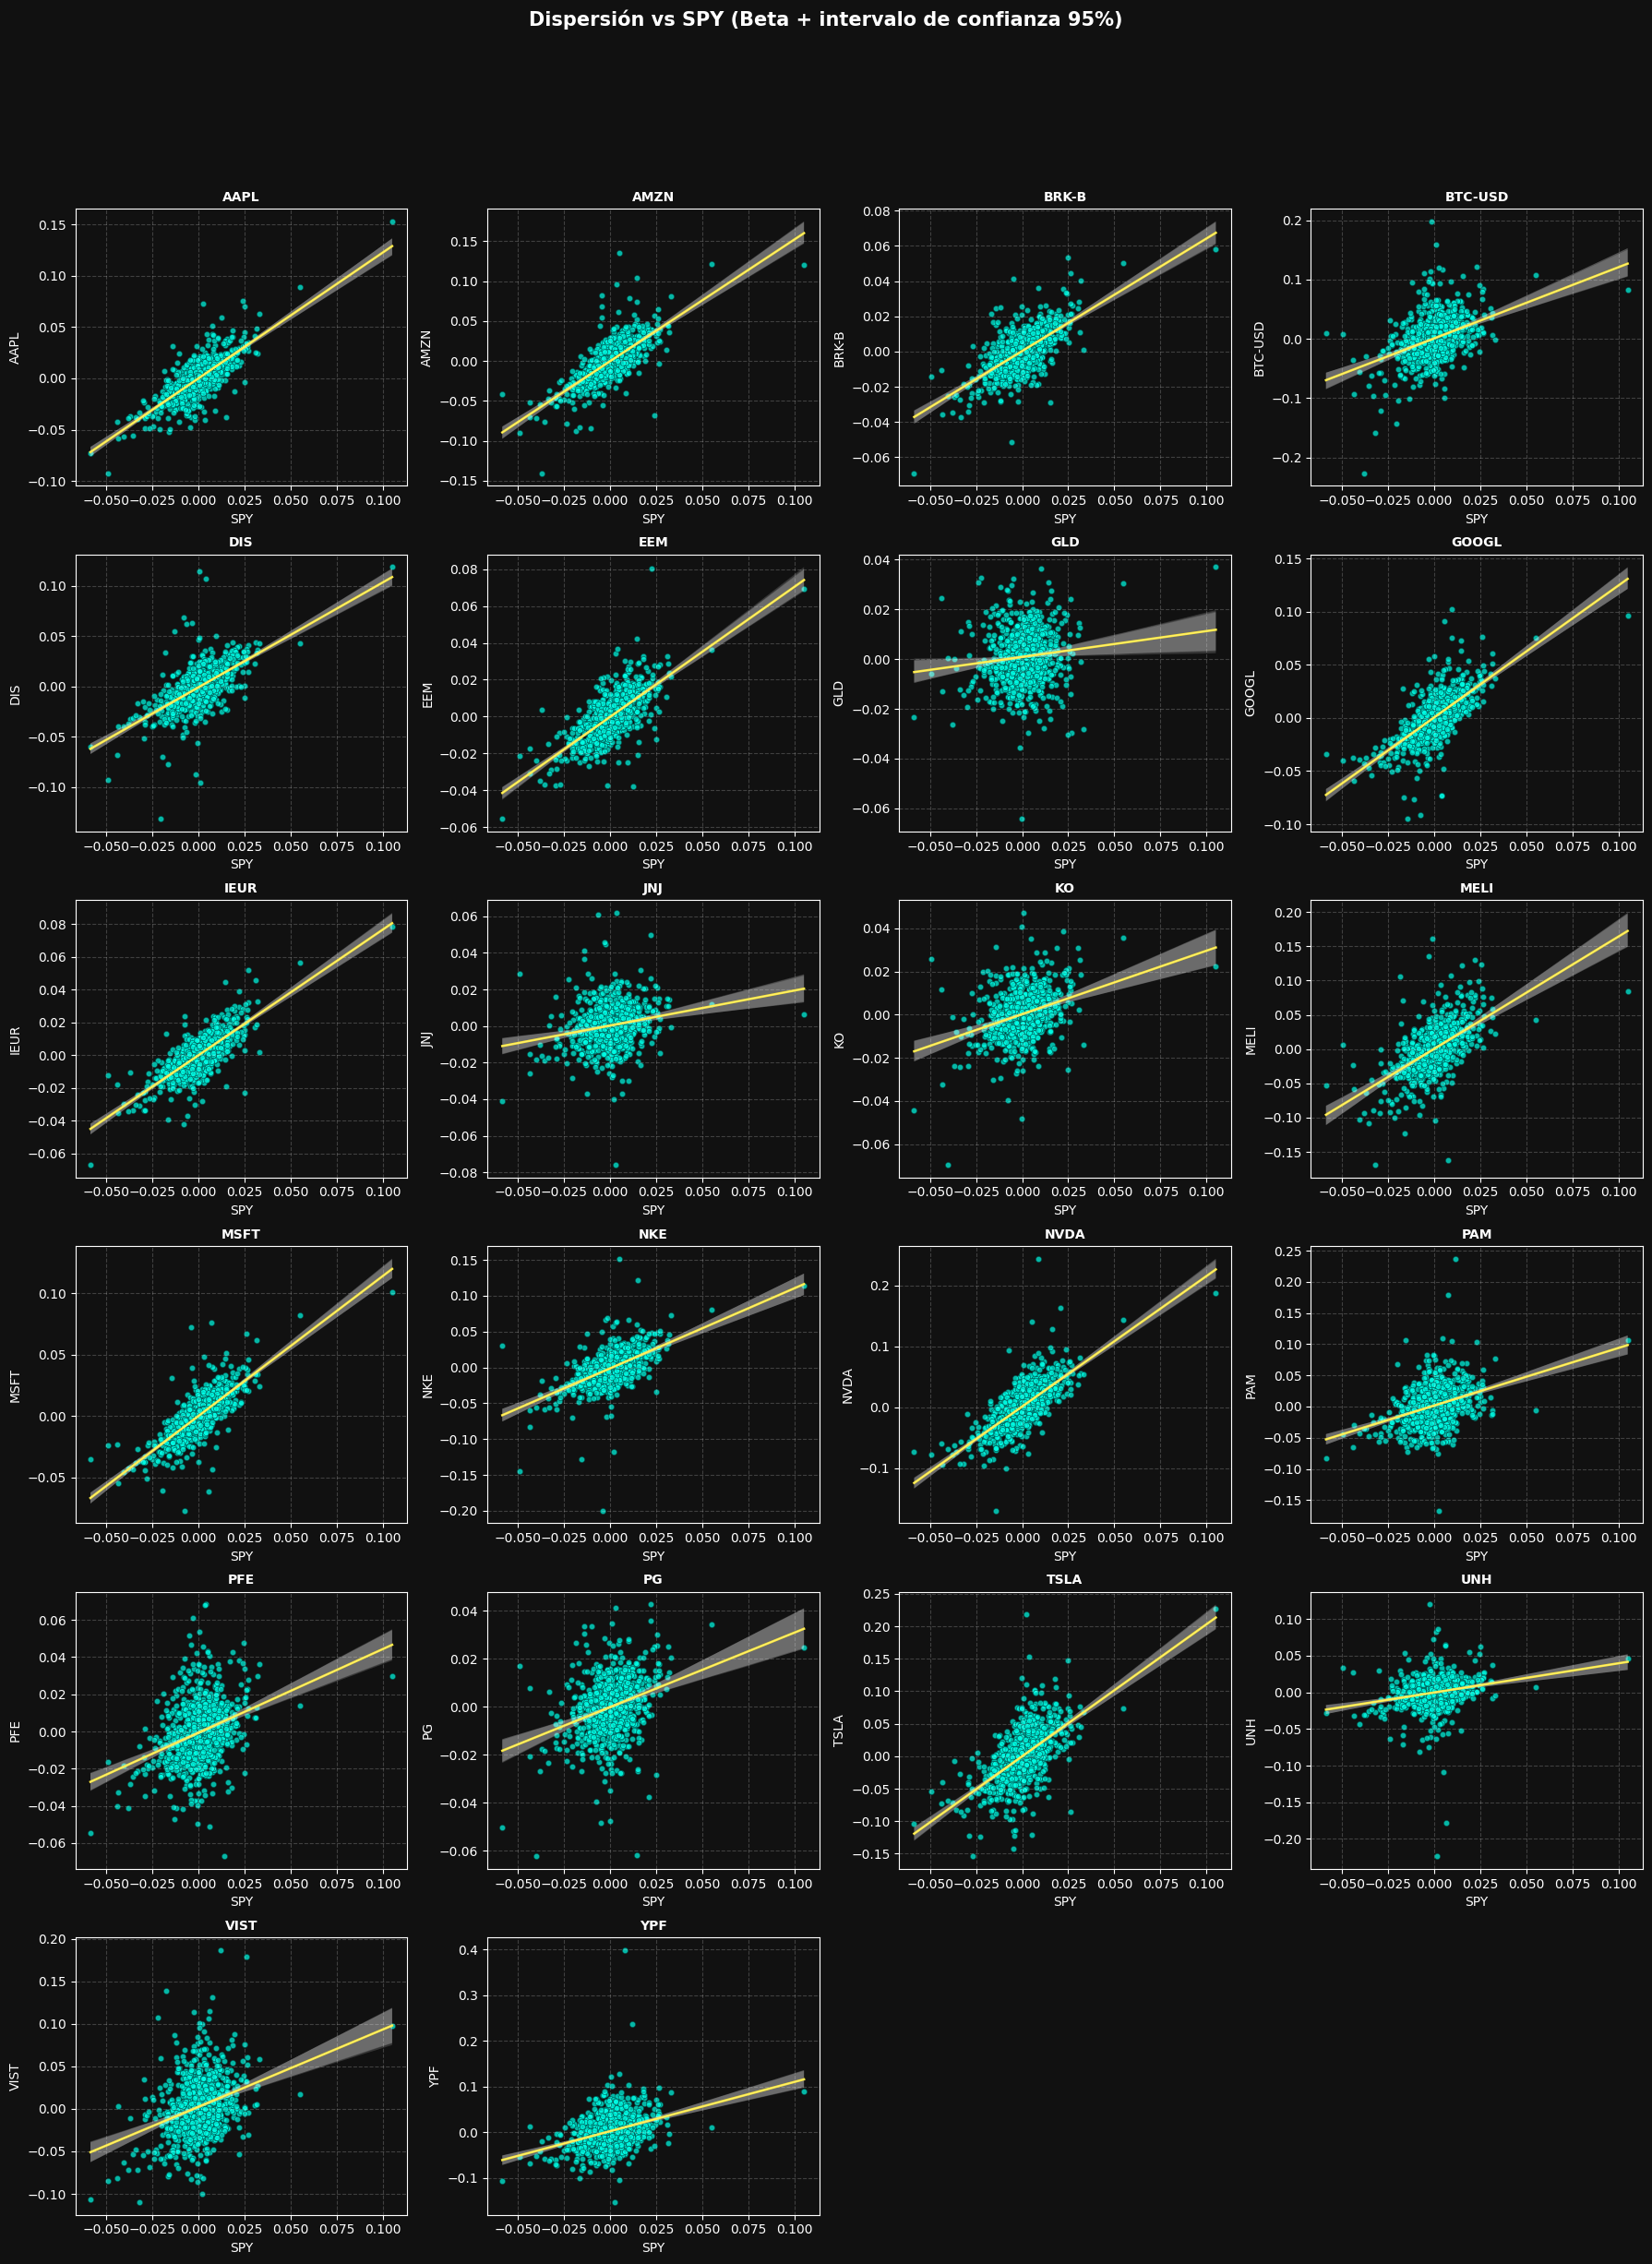

In [49]:
# Paso 14: Dispersión vs SPY

tickers = [t for t in ret_diarios.columns if t != "SPY"]
n, cols = len(tickers), 4
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, 4*rows), facecolor="#111111")
axes = axes.flatten()

for i, t in enumerate(tickers):
    ax = axes[i]
    ax.set_facecolor("#111111")

    # Puntos de dispersión
    ax.scatter(
        ret_diarios["SPY"], ret_diarios[t],
        alpha=0.7,
        s=20,
        facecolors="#00FFE7",    # relleno turquesa brillante
        edgecolors="#003F3C",    # contorno verde petróleo oscuro
        linewidths=0.5
    )

    # Línea de regresión amarilla (Beta)
    sns.regplot(
        x=ret_diarios["SPY"], y=ret_diarios[t],
        scatter=False, ax=ax, color="#ffeb3b", ci=None,
        line_kws={"lw":1.8}
    )
# Intervalos de confianza (líneas blancas difusas)
    for _ in range(3):
        sns.regplot(
            x=ret_diarios["SPY"], y=ret_diarios[t],
            scatter=False, ax=ax, color="white", ci=95,
            line_kws={"lw": 0.5, "alpha": 0.15}
    )

    # Estilo de cada subplot
    ax.set_title(t, fontsize=10, fontweight="bold", color="white")
    ax.tick_params(colors="white")
    ax.xaxis.label.set_color("white")
    ax.yaxis.label.set_color("white")
    ax.grid(True, linestyle="--", alpha=0.2, color="white")

# Quitar subplots vacíos
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Dispersión vs SPY (Beta + intervalo de confianza 95%)",
             fontsize=15, fontweight="bold", color="white", y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


In [50]:
# Paso 15: Ratios Performance

retornos = ret_diarios.copy()
activos = [t for t in tickers if t != "SPY"]
benchmark = "SPY"

r  = retornos[activos + [benchmark]].dropna(how="any")
rm = r[benchmark]
ra = r[activos]

mu_anual  = ra.mean() * 252
vol_anual = ra.std()  * (252 ** 0.5)

rf_anual = 0.05
sharpe   = (mu_anual - rf_anual) / vol_anual

downside   = ra.where(ra < 0, 0.0)
down_vol_a = downside.std() * (252 ** 0.5)
sortino    = (mu_anual - rf_anual) / down_vol_a

var_mkt = np.var(rm, ddof=0)
betas = pd.Series({t: (np.cov(ra[t], rm, ddof=0)[0,1] / var_mkt) if var_mkt!=0 else np.nan for t in activos})

treynor = (mu_anual - rf_anual) / betas

ratios = (
    pd.DataFrame({
        "Sharpe": sharpe,
        "Sortino": sortino,
        "Treynor": treynor
    })
    .replace([np.inf, -np.inf], np.nan)
    .round(3)
    .sort_index()
)

ratios



Sharpe  Sortino  Treynor
Ticker                           
AAPL      0.369    0.626    0.087
AMZN      0.270    0.454    0.067
BRK-B     0.582    0.985    0.162
BTC-USD   0.497    0.842    0.219
DIS      -0.343   -0.549   -0.100
EEM       0.076    0.131    0.020
GLD       1.110    1.918    1.708
GOOGL     0.637    1.087    0.168
IEUR      0.217    0.369    0.052
JNJ       0.251    0.425    0.225
KO        0.284    0.470    0.156
MELI      0.381    0.627    0.119
MSFT      0.348    0.591    0.082
NKE      -0.581   -0.898   -0.187
NVDA      1.016    1.832    0.257
PAM       0.943    1.754    0.488
PFE      -0.678   -1.156   -0.375
PG       -0.182   -0.285   -0.105
TSLA      0.259    0.448    0.079
UNH      -0.282   -0.396   -0.226
VIST      1.253    2.382    0.720
YPF       1.183    2.355    0.626

In [51]:
# Paso 16: Implementación modelo Fama-French de 3 factores

# Descargar factores Fama-French (diarios)
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip"
factors = pd.read_csv(url, skiprows=3)

factors = factors.rename(columns={"Unnamed: 0": "Date"})
factors = factors[factors["Date"].str.isnumeric()]
factors["Date"] = pd.to_datetime(factors["Date"], format="%Y%m%d")
factors = factors.set_index("Date").astype(float) / 100
factors = factors[["Mkt-RF", "SMB", "HML", "RF"]]

# Unión con retornos diarios (ajustar nombre de tu variable: ret_diarios)
data_ff = ret_diarios.join(factors, how="inner")

import statsmodels.api as sm

ff_results = {}
for ticker in [t for t in tickers if t != "SPY"]:  # todos menos SPY
    Ri = data_ff[ticker] - data_ff["RF"]
    X = data_ff[["Mkt-RF", "SMB", "HML"]]
    X = sm.add_constant(X)
    modelo = sm.OLS(Ri, X).fit()
    ff_results[ticker] = {
        "Alpha": round(modelo.params["const"], 4),
        "Beta_Mkt": round(modelo.params["Mkt-RF"], 4),
        "Beta_SMB": round(modelo.params["SMB"], 4),
        "Beta_HML": round(modelo.params["HML"], 4),
        "R2_ajustado": round(modelo.rsquared_adj, 4)
    }

ff_table = pd.DataFrame(ff_results).T.sort_index()
ff_table


Alpha  Beta_Mkt  Beta_SMB  Beta_HML  R2_ajustado
AAPL     0.0000    1.1742   -0.2847   -0.2316       0.6072
AMZN     0.0001    1.3683   -0.1500   -0.5443       0.5893
BRK-B    0.0000    0.8262   -0.2429    0.5187       0.5980
BTC-USD  0.0012    0.9932    0.6647   -0.2659       0.2008
DIS     -0.0006    1.0483    0.1162    0.1607       0.4088
EEM     -0.0001    0.6676    0.1354   -0.0030       0.4979
GLD      0.0007    0.0798    0.0573    0.0036       0.0097
GOOGL    0.0004    1.1186   -0.2606   -0.4583       0.5130
IEUR    -0.0001    0.7889    0.0304    0.1654       0.5943
JNJ     -0.0000    0.2809   -0.1890    0.2515       0.0810
KO      -0.0001    0.3933   -0.3204    0.1991       0.1646
MELI     0.0007    1.3549    0.2995   -0.8185       0.4110
MSFT     0.0001    1.0472   -0.4451   -0.4927       0.6685
NKE     -0.0011    1.0415    0.2825    0.0152       0.3278
NVDA     0.0018    1.8642   -0.4664   -1.1104       0.5988
PAM      0.0015    1.0008    0.0199    0.3530       0.1302
PFE     -0.0009    0.5099   -0.0666    0.2683       0.1177
PG      -0.0003    0.3769   -0.3284    0.0889       0.1271
TSLA     0.0003    1.7855    0.3944   -0.5493       0.3873
UNH     -0.0005    0.4541   -0.1546    0.1807       0.0523
VIST     0.0022    1.1152   -0.0471    0.7129       0.1314
YPF      0.0023    1.2640   -0.0162    0.6824       0.1410

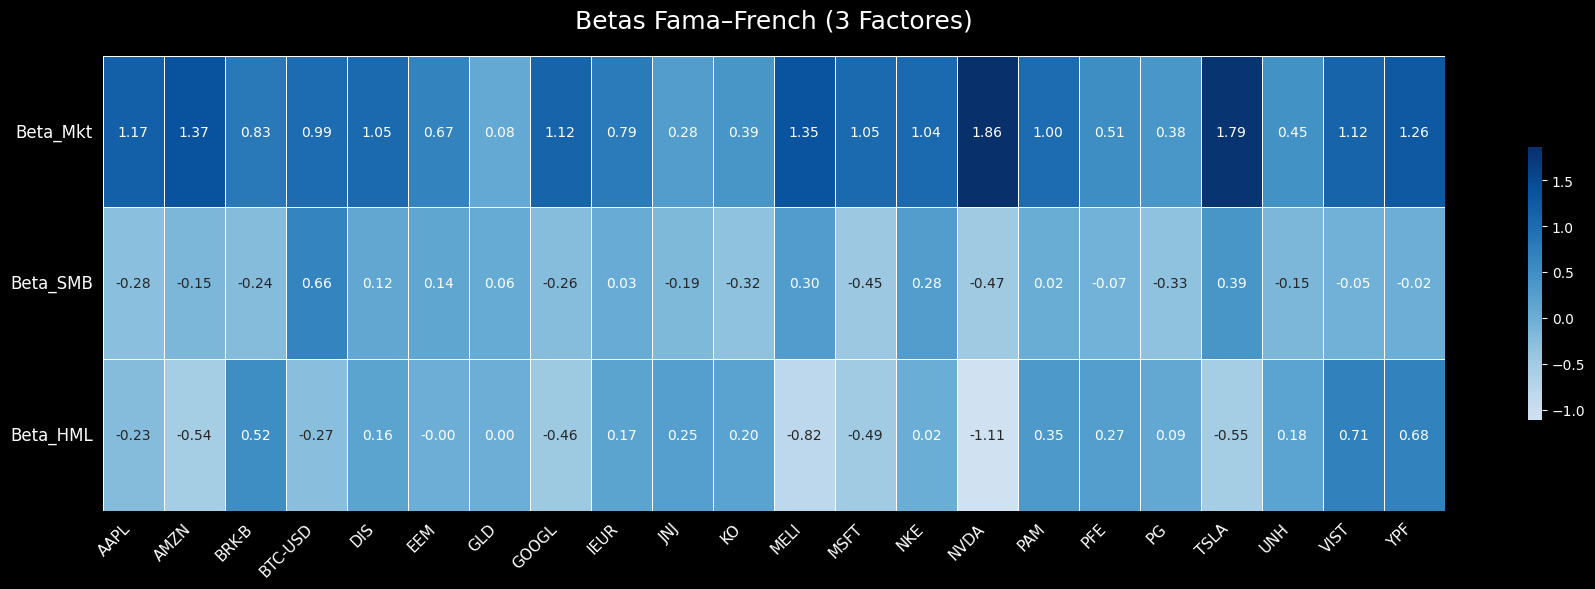

In [52]:
# Paso 17: Heatmap de betas

betas_ff = ff_table[["Beta_Mkt","Beta_SMB","Beta_HML"]]

plt.figure(figsize=(18, 6))
ax = sns.heatmap(
    betas_ff.T,
    annot=True,
    cmap='Blues',
    center=0,
    linewidths=0.7,
    fmt=".2f",
    cbar_kws={"shrink": 0.6}
)

ax.grid(False)
ax.tick_params(left=False, bottom=False, labelsize=11)

plt.title('Betas Fama–French (3 Factores)', fontsize=18, pad=20)
plt.xticks(rotation=45, ha="right", fontsize=11)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()





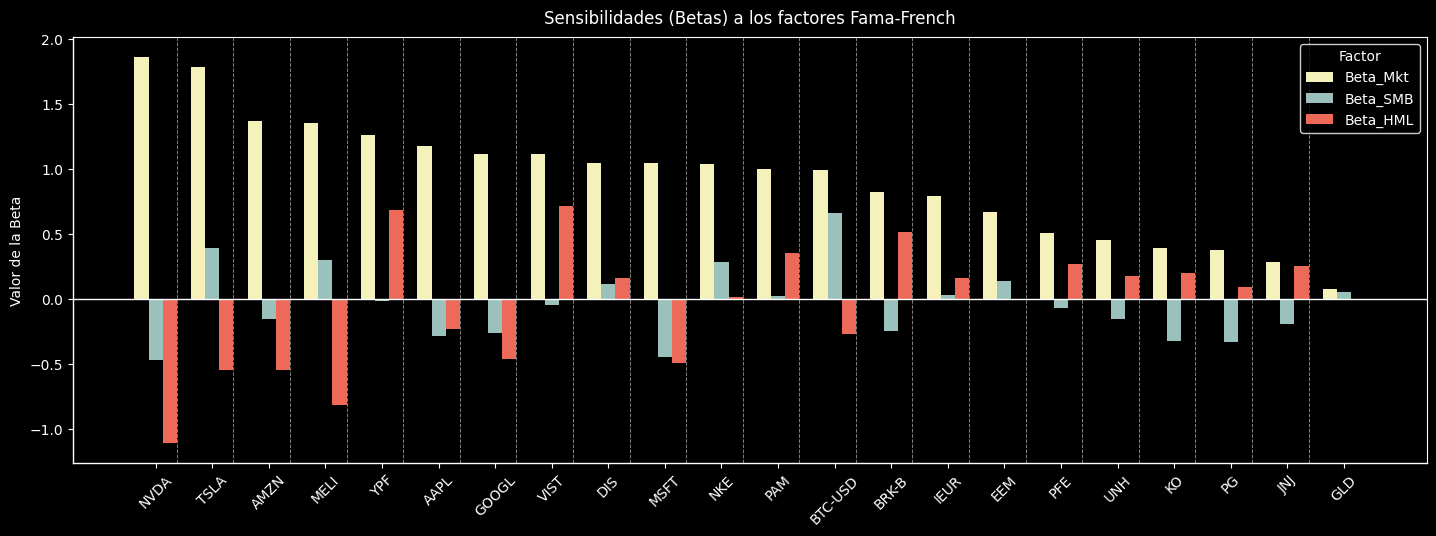

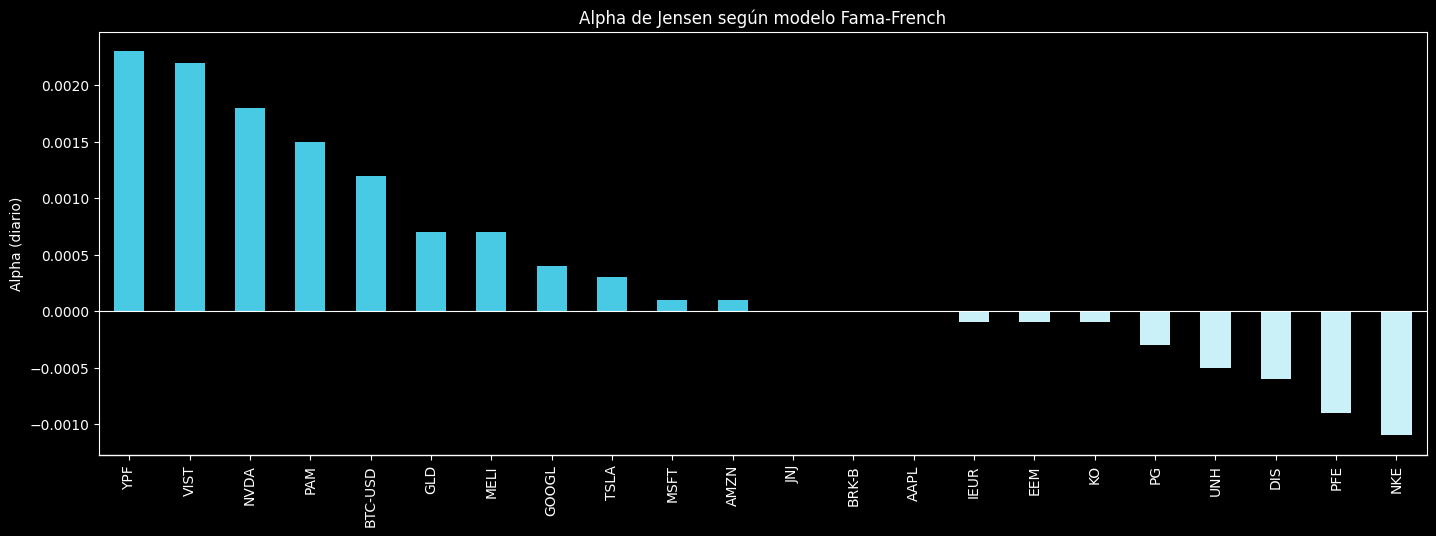

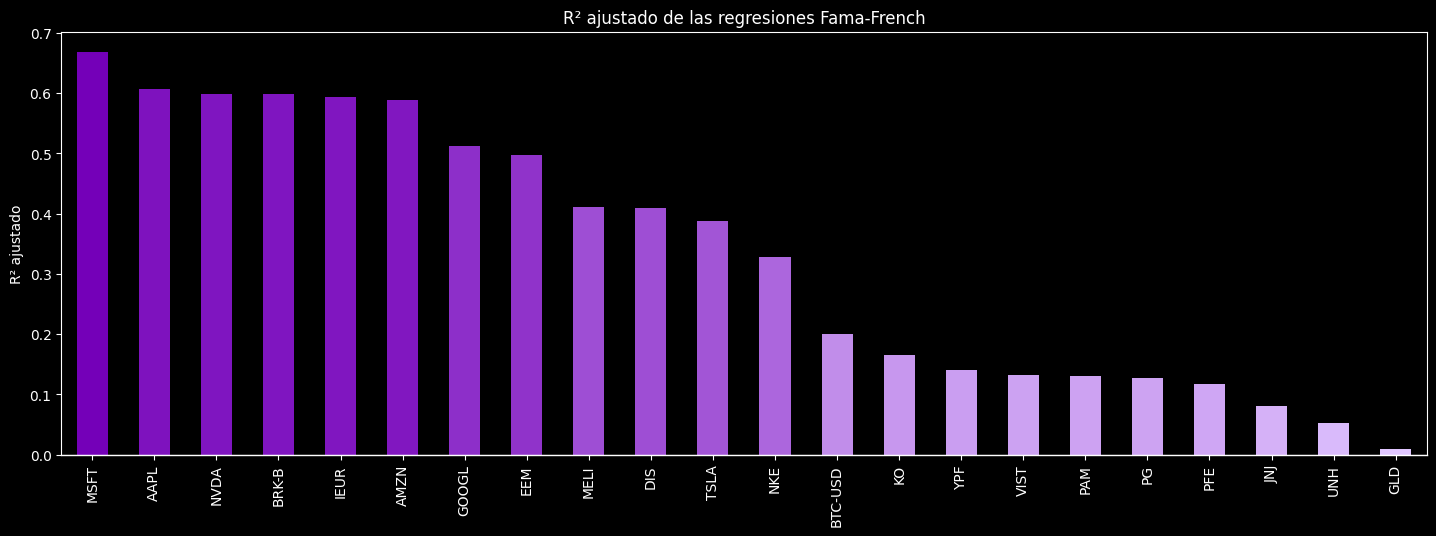

In [53]:
# Paso 18: Visualización Betas, Alpha, R² ajustado

import matplotlib.colors as mcolors

# Betas
betas = ff_table[["Beta_Mkt", "Beta_SMB", "Beta_HML"]].sort_values("Beta_Mkt", ascending=False)

x = np.arange(len(betas.index))
width = 0.25
metrics = betas.columns
colors = ["#f4f1bb", "#9bc1bc", "#ed6a5a"]

plt.figure(figsize=(15, 6))
for i, metric in enumerate(metrics):
    plt.bar(x + i * width, betas[metric], width, label=metric, color=colors[i])

# Líneas divisorias verticales grises
for i in range(len(betas.index) - 1):
    xpos = x[i] + width * len(metrics)
    plt.axvline(x=xpos - width/2, color="gray", linestyle="--", linewidth=0.7)

# Estilo general
plt.xticks(x + width, betas.index, rotation=45, color="white")
plt.title("Sensibilidades (Betas) a los factores Fama-French", color="white", pad=10)
plt.ylabel("Valor de la Beta", color="white")
plt.legend(title="Factor", facecolor="black", edgecolor="white", labelcolor="white")
plt.grid(False)

# Eje X
ax = plt.gca()
ax.set_facecolor("#000000")
ax.spines["bottom"].set_color("white")
ax.spines["bottom"].set_linewidth(1)
ax.spines["left"].set_color("white")
ax.spines["left"].set_linewidth(1)
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.axhline(0, color="white", linewidth=1.0)

plt.tight_layout(pad=3.0)
plt.show()



# Alpha
alpha_sorted = ff_table.sort_values("Alpha", ascending=False)["Alpha"]
colors = ["#48cae4" if v > 0 else "#caf0f8" for v in alpha_sorted]

plt.figure(figsize=(15,6))
alpha_sorted.plot(kind="bar", color=colors)
plt.axhline(0, color="white", linewidth=0.8)
plt.title("Alpha de Jensen según modelo Fama-French", color="white")
plt.ylabel("Alpha (diario)", color="white")
plt.grid(False)

# Eje X
ax = plt.gca()
ax.set_facecolor("#000000")
ax.spines["bottom"].set_color("white")
ax.spines["bottom"].set_linewidth(1)
ax.tick_params(axis='x', colors='white')

plt.tight_layout(pad=3.0)
plt.show()


# R² Ajustado
r2_sorted = ff_table.sort_values("R2_ajustado", ascending=False)["R2_ajustado"]

cmap = mcolors.LinearSegmentedColormap.from_list("custom_violet", ["#e0c6ff", "#7400b8"])
norm = mcolors.Normalize(vmin=r2_sorted.min(), vmax=r2_sorted.max())
colors = [cmap(norm(v)) for v in r2_sorted]

plt.figure(figsize=(15,6))
r2_sorted.plot(kind="bar", color=colors)
plt.axhline(0, color="white", linewidth=0.8)
plt.title("R² ajustado de las regresiones Fama-French", color="white")
plt.ylabel("R² ajustado", color="white")
plt.grid(False)

# Eje X
ax = plt.gca()
ax.set_facecolor("#000000")
ax.spines["bottom"].set_color("white")
ax.spines["bottom"].set_linewidth(1)
ax.tick_params(axis='x', colors='white')

plt.tight_layout(pad=3.0)
plt.show()

In [54]:
!pip install adjustText


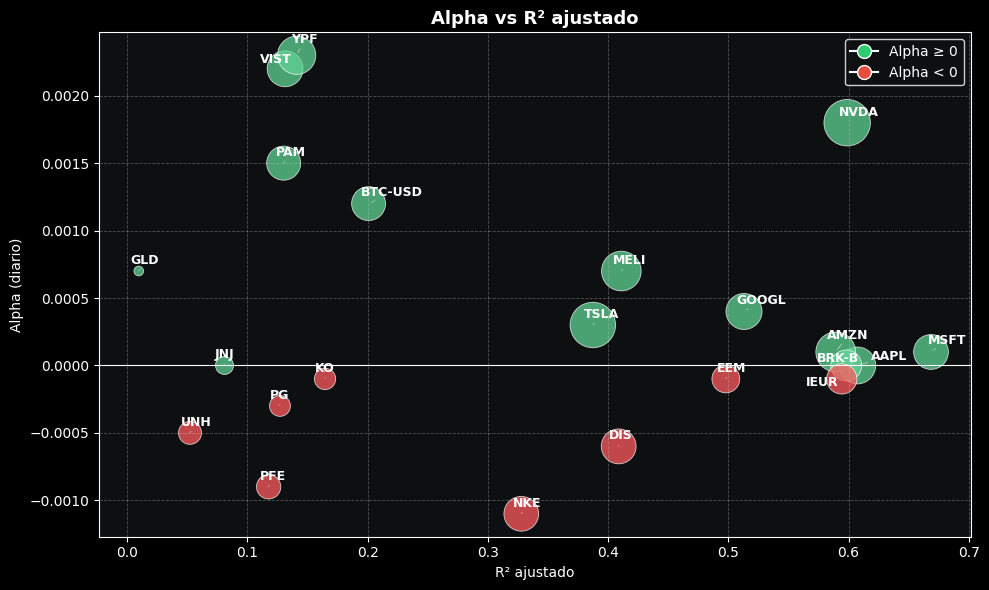

In [55]:
# Paso 19: Visualización Alpha vs R² ajustado (con etiquetas separadas)

from adjustText import adjust_text
from matplotlib.lines import Line2D

ff = ff_table.copy()
x = ff["R2_ajustado"]
y = ff["Alpha"]
s = (ff["Beta_Mkt"].abs() * 600).clip(30, 1200)

colors = np.where(y >= 0, "#60d394", "#ff5a5f")

plt.figure(figsize=(10,6))
plt.scatter(x, y, s=s, c=colors, alpha=0.75,
            edgecolors="white", linewidths=0.6)

# Crear etiquetas sin superposición
texts = []
for t in ff.index:
    texts.append(
        plt.text(
            x.loc[t], y.loc[t], t,
            fontsize=9, ha="center", va="bottom",
            color="white", fontweight="bold"
        )
    )

# Ajustar posiciones automáticamente
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="white", lw=0.3))

# Línea horizontal en 0
plt.axhline(0, color="white", linewidth=0.8)

# Ejes y títulos
plt.xlabel("R² ajustado", color="white")
plt.ylabel("Alpha (diario)", color="white")
plt.title("Alpha vs R² ajustado", color="white", fontsize=13, fontweight="bold")

# Fondo oscuro
plt.gca().set_facecolor("#0d0f11")

# Leyenda
legend_elems = [
    Line2D([0],[0], marker='o', color='w', label='Alpha ≥ 0', markerfacecolor='#2ecc71', markersize=10),
    Line2D([0],[0], marker='o', color='w', label='Alpha < 0', markerfacecolor='#e74c3c', markersize=10)
]
plt.legend(handles=legend_elems, loc="best", facecolor="#0d0f11",
           edgecolor="white", labelcolor="white")

# Cuadrícula suave
plt.grid(True, linestyle="--", linewidth=0.6, alpha=0.35, color="#cccccc")

plt.tight_layout()
plt.show()



In [56]:
# Paso 20: Simulación Monte Carlo: generación de 10.000 portafolios aleatorios

# Universo y retornos diarios (excluye SPY)
activos = [t for t in tickers if t != "SPY"]
data_returns = ret_diarios[activos].dropna()

# Semilla y cantidad de simulaciones
np.random.seed(42)
num_portafolios = 10000

# Parámetros anualizados
media_retornos = data_returns.mean() * 252
matriz_cov     = data_returns.cov()  * 252
tickers_sim    = data_returns.columns

# Simulación de portafolios aleatorios
resultados = {"Retorno": [], "Volatilidad": [], "Sharpe": [], "Pesos": []}

for _ in range(num_portafolios):
    pesos = np.random.random(len(tickers_sim))
    pesos /= pesos.sum()

    retorno      = float(pesos @ media_retornos.values)
    volatilidad  = float(np.sqrt(pesos @ matriz_cov.values @ pesos))
    sharpe_ratio = retorno / volatilidad

    resultados["Retorno"].append(retorno)
    resultados["Volatilidad"].append(volatilidad)
    resultados["Sharpe"].append(sharpe_ratio)
    resultados["Pesos"].append(pesos)

# DataFrame de resultados
portafolios = pd.DataFrame(resultados)
portafolios["Pesos"] = portafolios["Pesos"].apply(lambda x: np.round(x, 4))

portafolios.head()


Retorno  Volatilidad    Sharpe  \
0  0.199462     0.209336  0.952834   
1  0.177279     0.198857  0.891489   
2  0.191760     0.190775  1.005164   
3  0.261593     0.216959  1.205723   
4  0.138644     0.181784  0.762684   

                                               Pesos  
0  [0.0378, 0.096, 0.0739, 0.0604, 0.0158, 0.0157...  
1  [0.0295, 0.037, 0.046, 0.0793, 0.0202, 0.0519,...  
2  [0.0237, 0.0607, 0.0286, 0.0477, 0.0501, 0.016...  
3  [0.0135, 0.0769, 0.0071, 0.0946, 0.074, 0.019,...  
4  [0.0889, 0.0473, 0.012, 0.0715, 0.0762, 0.0562...

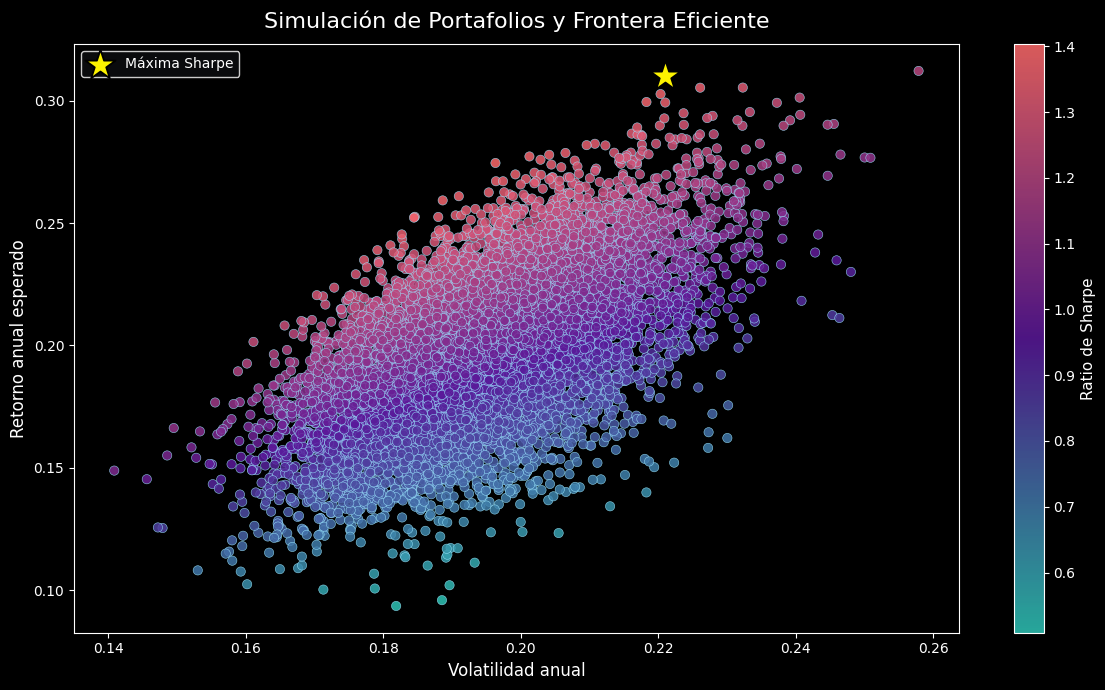

In [57]:
# Paso 21: Visualización de la frontera eficiente y portafolio de máxima Sharpe

plt.style.use("dark_background")

# Identificar portafolio óptimo
idx_max_sharpe = portafolios["Sharpe"].idxmax()
mejor_portafolio = portafolios.loc[idx_max_sharpe]

plt.figure(figsize=(12, 7))

# Colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "neo", ["#2ec4b6", "#5a189a", "#ff6b6b"]
)

# Nube de puntos
scatter = plt.scatter(
    portafolios["Volatilidad"], portafolios["Retorno"],
    c=portafolios["Sharpe"], cmap=cmap,
    alpha=0.85, s=45,
    edgecolors="#9be7ff", linewidths=0.4
)

# Barra de color
cbar = plt.colorbar(scatter)
cbar.set_label("Ratio de Sharpe", color="white", fontsize=11)
plt.setp(cbar.ax.get_yticklabels(), color="white")

# Portafolio óptimo (estrella dorada)
plt.scatter(
    mejor_portafolio["Volatilidad"], mejor_portafolio["Retorno"],
    color="#fcf300", marker="*", s=520, edgecolors="black", linewidths=1.3,
    label="Máxima Sharpe"
)

# Estética general
plt.title("Simulación de Portafolios y Frontera Eficiente", fontsize=16, color="white", pad=12)
plt.xlabel("Volatilidad anual", color="white", fontsize=12)
plt.ylabel("Retorno anual esperado", color="white", fontsize=12)
plt.legend(facecolor="#0D0F11", edgecolor="white")
plt.grid(False)

# Bordes del gráfico en blanco
ax = plt.gca()
for sp in ax.spines.values():
    sp.set_color("white")

plt.tight_layout()
plt.show()



In [58]:
# Paso 22: Métricas del portafolio óptimo (Máxima Sharpe)
metricas_optimas = mejor_portafolio[["Retorno", "Volatilidad", "Sharpe"]].copy()

# Formatear los valores
metricas_optimas["Retorno"] = f"{metricas_optimas['Retorno']*100:.2f}%"
metricas_optimas["Volatilidad"] = f"{metricas_optimas['Volatilidad']*100:.2f}%"
metricas_optimas["Sharpe"] = f"{metricas_optimas['Sharpe']:.2f}"

# Mostrar como Serie (vertical)
metricas_optimas = pd.Series(metricas_optimas)
metricas_optimas.name = "Métricas del Portafolio Óptimo"
display(metricas_optimas)




Retorno        31.01%
Volatilidad    22.10%
Sharpe           1.40
Name: Métricas del Portafolio Óptimo, dtype: object

In [59]:
# Paso 23: 10.000 carteras válidas con pisos y techos para PAM/YPF/VIST

activos = [t for t in tickers if t != "SPY"]
data_returns = ret_diarios[activos].dropna()

np.random.seed(42)
TARGET = 10_000
BATCH  = 50_000

media_retornos = data_returns.mean() * 252
matriz_cov     = data_returns.cov()  * 252
tickers_sim    = data_returns.columns


alpha = np.full(len(tickers_sim), 6.0)
limitados = ["YPF", "PAM", "VIST"]
idx_lim = [tickers_sim.get_loc(t) for t in limitados if t in tickers_sim]
for i in idx_lim:
    alpha[i] = 2.0


floor = 0.018
cap   = 0.03

valid = []
total_gen = 0

while sum(len(v) for v in valid) < TARGET:
    W = np.random.dirichlet(alpha, size=BATCH)
    total_gen += BATCH
    ok = np.ones(len(W), dtype=bool)
    if idx_lim:
        ok &= (W[:, idx_lim] <= cap).all(axis=1)
        ok &= (W[:, idx_lim] >= floor).all(axis=1)
    valid.append(W[ok])

W_keep = np.vstack(valid)[:TARGET]
print(f"Generadas: {total_gen:,} | Aceptadas: {W_keep.shape[0]:,} | Tasa: {W_keep.shape[0]/total_gen:.1%}")

# Métricas vectorizadas
rets = W_keep @ media_retornos.values
vols = (np.einsum('ij,jk,ik->i', W_keep, matriz_cov.values, W_keep))**0.5
sharpes = rets / vols

portafolios = pd.DataFrame({"Retorno": rets, "Volatilidad": vols, "Sharpe": sharpes})
portafolios["Pesos"] = list(W_keep.round(4))

# Portafolio de máxima Sharpe
idx_max = portafolios["Sharpe"].idxmax()
mejor_portafolio = portafolios.loc[idx_max]

# Pesos óptimos (%)
pesos_optimos = pd.Series(mejor_portafolio["Pesos"], index=tickers_sim).sort_values(ascending=False)
pesos_optimos_pct = (pesos_optimos * 100).round(2).astype(str) + '%'
display(pesos_optimos_pct)


Generadas: 750,000 | Aceptadas: 10,000 | Tasa: 1.3%


Ticker
NVDA       9.58%
KO         9.49%
AAPL       7.43%
GLD        7.07%
BRK-B      6.91%
AMZN        6.8%
PG         6.55%
MSFT       6.46%
GOOGL      6.25%
BTC-USD    3.82%
IEUR       3.29%
UNH        3.26%
PFE        3.06%
JNJ        2.95%
TSLA       2.93%
PAM        2.68%
MELI       2.47%
EEM        2.26%
DIS        1.96%
YPF        1.93%
VIST       1.83%
NKE        1.03%
dtype: object

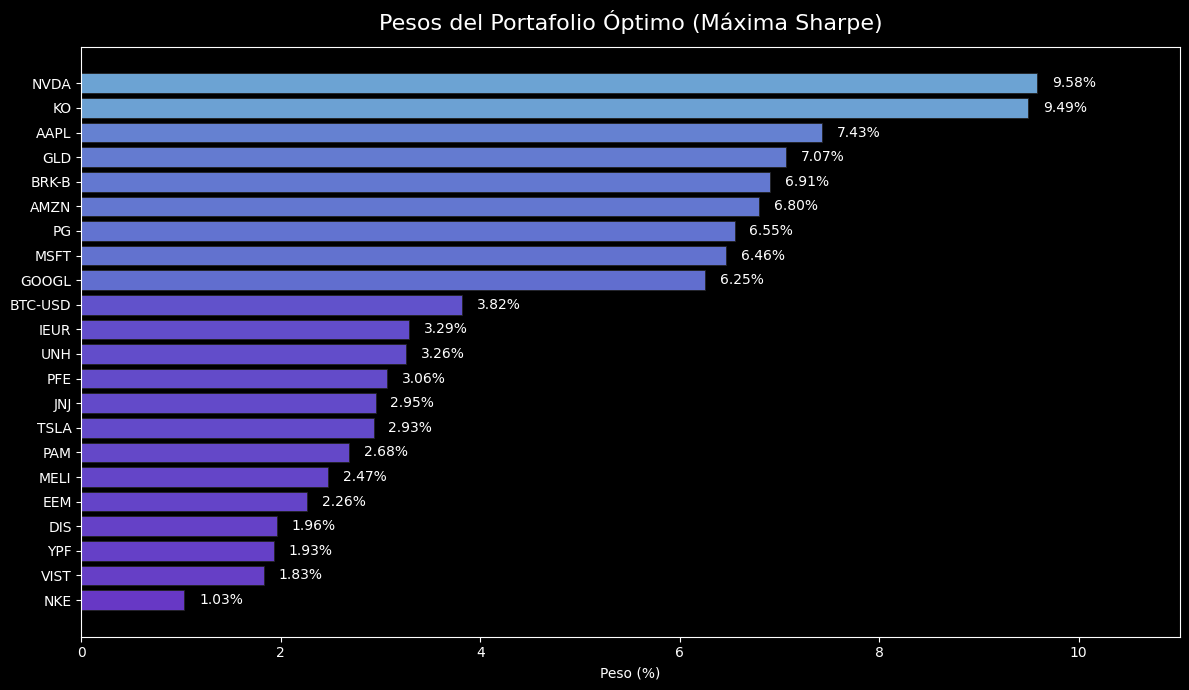

In [60]:
# Paso 24: Visualización de la composición del portafolio óptimo
plt.style.use("dark_background")

w = pd.Series(mejor_portafolio["Pesos"], index=tickers_sim).astype(float)
w_pct = (w * 100).round(2)
w_sorted = w_pct.sort_values(ascending=False)

cmap = mcolors.LinearSegmentedColormap.from_list("peso_grad", [(0.0,"#7400b8"),(0.5,"#5e60ce"),(1.0,"#80ffdb")])
norm = mcolors.Normalize(vmin=w_sorted.min() - 6, vmax=w_sorted.max() + 6)
colors = [cmap(norm(v)) for v in w_sorted[::-1]]

fig, ax = plt.subplots(figsize=(12,7))
ax.barh(w_sorted.index[::-1], w_sorted.values[::-1], color=colors, edgecolor="#222", linewidth=0.6)

ax.set_title("Pesos del Portafolio Óptimo (Máxima Sharpe)", fontsize=16, color="white", pad=12)
ax.set_xlabel("Peso (%)", color="white"); ax.set_ylabel("")
ax.tick_params(colors="white")
ax.grid(False)

for y, v in enumerate(w_sorted.values[::-1]):
    ax.text(v + 0.15, y, f"{v:.2f}%", va="center", color="white", fontsize=10)

ax.margins(x=0.15)
for sp in ax.spines.values(): sp.set_color("white")
plt.tight_layout(); plt.show()


In [61]:
# Paso 25: construir df_pais desde el portafolio óptimo

# Pesos del portafolio óptimo (%)
w = pd.Series(mejor_portafolio["Pesos"], index=tickers_sim).astype(float)
w_pct = (w * 100).round(2)

# País por ticker
paises = {}
for t in w_pct.index:
    try:
        info = yf.Ticker(t).info
        paises[t] = info.get("country") or "Desconocido"
    except Exception:
        paises[t] = "Desconocido"

# ETFs/cripto
fallback_pais = {
    "GLD": "Global",
    "EEM": "Global",
    "IEUR": "Europa",
    "BTC-USD": "Global",
    "SPY": "United States"
}
for t, p in fallback_pais.items():
    if t in w_pct.index and (paises.get(t) in [None, "Desconocido", ""]):
        paises[t] = p

# Overrides manuales
overrides_pais = {
    "MELI": "Argentina - Latam",
    "VIST": "Argentina",
    "YPF": "Argentina",
    "PAM": "Argentina",
}
for t, p in overrides_pais.items():
    if t in w_pct.index:
        paises[t] = p

# DataFrame final para el sunburst
df_pais = (
    pd.DataFrame({"Ticker": w_pct.index, "Peso": w_pct.values})
      .assign(Pais=lambda d: d["Ticker"].map(paises).fillna("Desconocido"))
)


In [62]:
# Paso 26: Sunburst por país/sector

import colorsys
import plotly.graph_objects as go


# Paleta base por país
colores_pais = {
    "United States": "#9b5de5",
    "Global": "#f15bb5",
    "Europa": "#fee440",
    "Argentina": "#00bbf9",
    "Argentina - Latam": "#00f5d4",
    "Desconocido": "#dee2ff"
}

def hex_to_rgb(hexstr):
    hexstr = hexstr.lstrip("#")
    return tuple(int(hexstr[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hex(rgb):
    return "#%02x%02x%02x" % rgb

def shade_from_base(base_hex, t, darker_when_bigger=True):
    r, g, b = hex_to_rgb(base_hex)
    h, l, s = colorsys.rgb_to_hls(r/255.0, g/255.0, b/255.0)
    l_min, l_max = 0.30, 0.70
    L = l_max - t*(l_max - l_min) if darker_when_bigger else l_min + t*(l_max - l_min)
    R, G, B = colorsys.hls_to_rgb(h, L, s)
    return rgb_to_hex((int(R*255), int(G*255), int(B*255)))

# Jerarquía
root = "Portafolio"
labels  = [root]
parents = [""]
values  = [df_pais["Peso"].sum()]
colors  = ["#0d0f11"]

paises = df_pais["Pais"].unique().tolist()
peso_pais = df_pais.groupby("Pais")["Peso"].sum()

# Países
for p in paises:
    labels.append(p)
    parents.append(root)
    values.append(float(peso_pais.loc[p]))
    colors.append(colores_pais.get(p, "#4cc9f0"))

# Tickers con degradé dentro de cada país
for p in paises:
    base = colores_pais.get(p, "#4cc9f0")
    dfp = df_pais[df_pais["Pais"] == p].copy().sort_values("Peso", ascending=False)
    v = dfp["Peso"].values
    t_norm = (v - v.min()) / (v.max() - v.min()) if v.max() != v.min() else [0.5]*len(v)
    for (tick, peso, t) in zip(dfp["Ticker"], dfp["Peso"], t_norm):
        labels.append(tick)
        parents.append(p)
        values.append(float(peso))
        colors.append(shade_from_base(base, t, darker_when_bigger=True))

# Figura
fig = go.Figure(go.Sunburst(
    labels=labels,
    parents=parents,
    values=values,
    branchvalues="total",
    marker=dict(colors=colors, line=dict(color="rgba(13,15,17,1)", width=1.1)),
    textinfo="label+value+percent parent",
    texttemplate="<b>%{label}</b><br>%{value:.2f}%",
    textfont=dict(color="white", size=12),
    hovertemplate="<b>%{label}</b><br>Peso: %{value:.2f}%<br>Del país: %{percentParent:.1%}<extra></extra>",
))

# Texto negro para sectores claros (Europa, IEUR, Argentina-Latam, MELI)
sectores_claros = ["Europa", "IEUR", "Argentina - Latam", "MELI"]
fig.update_traces(
    selector=dict(type="sunburst"),
    textfont=dict(
        color=[
            "black" if any(k.lower() in l.lower() for k in sectores_claros) else "white"
            for l in labels
        ],
        size=12
    )
)

fig.update_layout(
    title="Composición del Portafolio por País",
    paper_bgcolor="#0d0f11",
    plot_bgcolor="#0d0f11",
    font=dict(color="#f5f5f5", family="Orbitron, sans-serif"),
    margin=dict(l=10, r=10, t=50, b=10)
)

fig.show()





In [69]:
# Paso 27: Treemap por país/sector

import plotly.express as px

# Pesos del óptimo (%)
w = pd.Series(mejor_portafolio["Pesos"], index=tickers_sim).astype(float)
w_pct = (w * 100).round(2)

# Datos desde Yahoo Finance (sector)
sectores = {}
for t in tickers_sim:
    try:
        info = yf.Ticker(t).info
        sectores[t] = info.get("sector") or "Desconocido"
    except Exception:
        sectores[t] = "Desconocido"

# Fallbacks
fallback_sector = {
    "GLD":"ETF/Commodity", "EEM":"ETF/Emergentes",
    "IEUR":"ETF/Europa", "BTC-USD":"Cripto"
}
for t, s in fallback_sector.items():
    if t in sectores and sectores[t] in [None, "Desconocido", ""]:
        sectores[t] = s

# DataFrame
df_sec = (
    pd.DataFrame({"Ticker": w_pct.index, "Peso": w_pct.values})
      .assign(Sector=lambda d: d["Ticker"].map(sectores).fillna("Desconocido"))
)

# Treemap
fig_treemap_sector = px.treemap(
    df_sec,
    path=["Sector","Ticker"], values="Peso", color="Peso",
    color_continuous_scale=["#7400b8","#5e60ce","#64dfdf","#80ffdb"],
    template="plotly_dark",
    title="Composición por Sector"
)

# Etiquetas
fig_treemap_sector.update_traces(
    texttemplate="%{label}<br>%{value:.2f}%",
    textfont_size=14,
    textfont_color="white"
)

# Cambiar solo NVDA a texto negro
for trace in fig_treemap_sector.data:
    if hasattr(trace, "labels"):
        new_colors = ["white"] * len(trace.labels)
        for i, label in enumerate(trace.labels):
            if label in ["NVDA", "Technology", "Information Technology"]:
                new_colors[i] = "black"
        trace.textfont = dict(color=new_colors)

fig_treemap_sector.update_layout(margin=dict(l=10, r=10, t=40, b=10))
fig_treemap_sector.show()


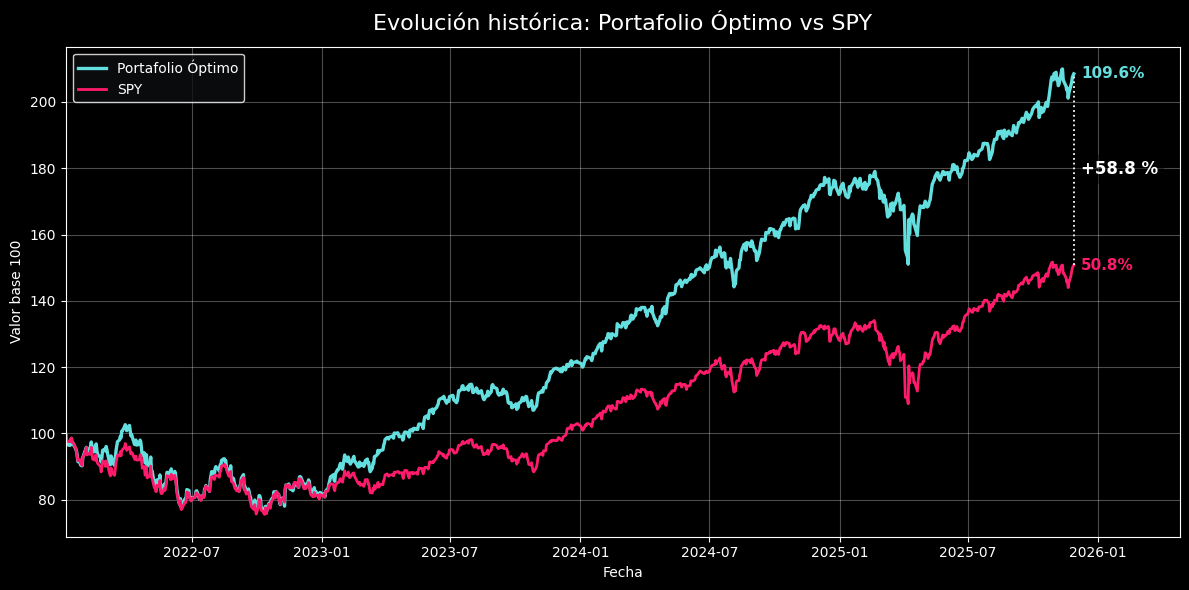

In [64]:
# Paso 28 — Evolución histórica: Portafolio Óptimo vs SPY

# Descargar precios ajustados
tickers_comp = list(tickers_sim) + ["SPY"]
raw = yf.download(tickers_comp, start="2022-01-01", progress=False, auto_adjust=True)

# Manejo robusto del formato
if isinstance(raw.columns, pd.MultiIndex):
    data_prices = raw.xs("Close", level=0, axis=1)
else:
    data_prices = raw["Close"].to_frame() if raw.ndim == 1 else raw

data_prices = data_prices.dropna(how="any")

# Retornos diarios
ret_diarios_all = data_prices.pct_change().dropna()

# Pesos del portafolio óptimo
w_opt = pd.Series(mejor_portafolio["Pesos"], index=tickers_sim).astype(float)

# Retornos diarios y evolución
ret_port_opt = (ret_diarios_all[tickers_sim] * w_opt).sum(axis=1)

base = 100
evol_port = (1 + ret_port_opt).cumprod() * base
evol_spy  = (1 + ret_diarios_all["SPY"]).cumprod() * base

df_comp = pd.concat([evol_port, evol_spy], axis=1).dropna()
df_comp.columns = ["Portafolio Óptimo", "SPY"]

# Rendimientos finales
ret_final_port = (df_comp["Portafolio Óptimo"].iloc[-1] / df_comp["Portafolio Óptimo"].iloc[0] - 1) * 100
ret_final_spy  = (df_comp["SPY"].iloc[-1] / df_comp["SPY"].iloc[0] - 1) * 100
diff = ret_final_port - ret_final_spy

# Gráfico
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(df_comp.index, df_comp["Portafolio Óptimo"], lw=2.4, color="#64dfdf", label="Portafolio Óptimo")
ax.plot(df_comp.index, df_comp["SPY"],               lw=2.0, color="#ff1b6b", label="SPY")

# Margen a la derecha para textos
ax.set_xlim(df_comp.index[0], df_comp.index[-1] + pd.Timedelta(days=150))

# Etiquetas
x_text = df_comp.index[-1] + pd.Timedelta(days=10)
ax.text(x_text, df_comp["Portafolio Óptimo"].iloc[-1],
        f"{ret_final_port:.1f}%", color="#64dfdf", fontsize=11, va="center", ha="left", fontweight="bold")
ax.text(x_text, df_comp["SPY"].iloc[-1],
        f"{ret_final_spy:.1f}%", color="#ff1b6b", fontsize=11, va="center", ha="left", fontweight="bold")

# Llave visual + diferencia
y1, y2 = df_comp["SPY"].iloc[-1], df_comp["Portafolio Óptimo"].iloc[-1]
ymin, ymax = (min(y1, y2), max(y1, y2))
ax.vlines(x=df_comp.index[-1], ymin=ymin, ymax=ymax, colors="white", linestyles="dotted", linewidth=1.3)
ax.text(x_text, (y1+y2)/2, f"{diff:+.1f} %", color="white", fontsize=12,
        va="center", ha="left", fontweight="bold", bbox=dict(fc=(0,0,0,0.4), ec="none"))

# Estilo
ax.set_title("Evolución histórica: Portafolio Óptimo vs SPY", fontsize=16, color="white", pad=12)
ax.set_xlabel("Fecha", color="white"); ax.set_ylabel("Valor base 100", color="white")
ax.legend(facecolor="#0D0F11", edgecolor="white", loc="upper left")
ax.grid(alpha=0.3)
for s in ax.spines.values(): s.set_color("white")

plt.tight_layout()
plt.show()




In [65]:
# Paso 29: Métricas históricas comparativas (Portafolio vs SPY)

# Retornos acumulados y valores finales (base 100)
valor_final_port = evol_port.iloc[-1]
valor_final_spy  = evol_spy.iloc[-1]

ret_acum_port = (valor_final_port / evol_port.iloc[0] - 1) * 100
ret_acum_spy  = (valor_final_spy  / evol_spy.iloc[0]  - 1) * 100

# Métricas anualizadas
rf_anual = 0.05  # Tasa libre de riesgo anual

ret_spy  = ret_diarios_all["SPY"].dropna()
ret_port = ret_port_opt.reindex(ret_spy.index).dropna()

idx = ret_spy.index.intersection(ret_port.index)
ret_spy  = ret_spy.loc[idx]
ret_port = ret_port.loc[idx]

# CAGR (retorno anual geométrico)
ret_anual_port = (1 + ret_port).prod()**(252/len(ret_port)) - 1
ret_anual_spy  = (1 + ret_spy).prod()**(252/len(ret_spy))   - 1

# Volatilidad anual
vol_anual_port = ret_port.std() * np.sqrt(252)
vol_anual_spy  = ret_spy.std()  * np.sqrt(252)

# Sharpe anual (geométrico con RF)
sharpe_port = (ret_anual_port - rf_anual) / vol_anual_port if vol_anual_port > 0 else np.nan
sharpe_spy  = (ret_anual_spy  - rf_anual) / vol_anual_spy  if vol_anual_spy  > 0 else np.nan

# Tabla final formateada
metricas_hist = pd.DataFrame({
    "Retorno acumulado total":      [f"{ret_acum_port:.2f}%",      f"{ret_acum_spy:.2f}%"],
    "Valor final (base 100)":       [f"{valor_final_port:.2f}",    f"{valor_final_spy:.2f}"],
    "Retorno anual histórico":      [f"{ret_anual_port*100:.2f}%", f"{ret_anual_spy*100:.2f}%"],
    "Volatilidad anual histórica":  [f"{vol_anual_port*100:.2f}%", f"{vol_anual_spy*100:.2f}%"],
    "Sharpe histórico":             [f"{sharpe_port:.2f}",         f"{sharpe_spy:.2f}"]
}, index=["Portafolio Óptimo", "SPY"])


# Mostrar con estilo oscuro
display(
    metricas_hist.style
    .set_caption("Métricas históricas comparativas (Portafolio vs SPY)")
    .set_table_styles([
        {"selector": "th", "props": [
            ("background-color", "#1E1E1E"),
            ("color", "white"),
            ("padding", "8px 12px"),
            ("font-size", "12px"),
            ("text-align", "center"),
            ("vertical-align", "middle"),
            ("border", "1px solid #444")
        ]},
        {"selector": "td", "props": [
            ("background-color", "#2B2B2B"),
            ("color", "#E0E0E0"),
            ("padding", "8px 12px"),
            ("font-size", "12px"),
            ("text-align", "center"),
            ("border", "1px solid #444")
        ]},
        {"selector": "caption", "props": [
            ("caption-side", "top"),
            ("font-size", "14px"),
            ("font-weight", "bold"),
            ("color", "#E0E0E0"),
            ("text-align", "center"),
            ("padding", "6px")
        ]}
    ])
    .set_properties(border="1px solid #444", width="160px")
)



In [66]:
# Paso 30: Cálculo de máxima caída (Drawdown) y recuperación

def drawdown_episodes(series: pd.Series) -> pd.DataFrame:
    series = series.dropna().astype(float)
    roll_max = series.cummax()
    dd = series / roll_max - 1.0  # negativo durante caídas

    is_dd = dd < 0
    groups = (is_dd.ne(is_dd.shift(fill_value=False))).cumsum()

    rows = []
    for _, seg in dd.groupby(groups):
        if not is_dd.loc[seg.index[0]]:
            continue
        start   = seg.index[0]
        trough  = seg.idxmin()
        depth   = seg.loc[trough] * 100
        peakval = roll_max.loc[start]

        rec_mask = series.loc[start:].ge(peakval)
        if rec_mask.any():
            rec_date   = rec_mask.idxmax()
            total_days = (rec_date - start).days
            post_days  = (rec_date - trough).days
        else:
            rec_date   = pd.NaT
            total_days = np.nan
            post_days  = np.nan

        rows.append({
            "peak_date": start,
            "trough_date": trough,
            "recovery_date": rec_date,
            "depth_pct": depth,
            "peak_to_trough_days": (trough - start).days,
            "trough_to_recovery_days": post_days,
            "total_days": total_days
        })

    return pd.DataFrame(rows).sort_values("peak_date")

# Calcula episodios
ep_port = drawdown_episodes(evol_port)
ep_spy  = drawdown_episodes(evol_spy)

def resumen_con_fechas(dd_episodes: pd.DataFrame, serie: pd.Series) -> dict:
    if dd_episodes.empty:
        return {
            "Máx DD (%)": "0.00%",
            "Fecha máximo": "—",
            "Fecha mínimo": "—",
            "Fecha recuperación": "—",
            "Días máximo → recuperación": 0,
            "Días mínimo → recuperación": 0,
            "Bajo agua (hoy)": 0
        }

    worst = dd_episodes.loc[dd_episodes["depth_pct"].idxmin()]

    fmt = "%d-%m-%Y"
    f_peak = worst["peak_date"].strftime(fmt)
    f_trgh = worst["trough_date"].strftime(fmt)
    f_recv = worst["recovery_date"].strftime(fmt) if pd.notna(worst["recovery_date"]) else "—"

    roll_max = serie.cummax()
    dd_today = (serie.iloc[-1] / roll_max.iloc[-1]) - 1.0
    if dd_today < 0:
        dd = serie / roll_max - 1.0
        zeros = dd[dd == 0]
        last_peak_date = zeros.index.max() if not zeros.empty else dd.index[0]
        current_underwater_days = (dd.index[-1] - last_peak_date).days
    else:
        current_underwater_days = 0

    return {
        "Máx DD (%)": f"{worst['depth_pct']:.2f}%",
        "Fecha máximo": f_peak,
        "Fecha mínimo": f_trgh,
        "Fecha recuperación": f_recv,
        "Días máximo → recuperación": int(worst["total_days"]) if pd.notna(worst["total_days"]) else "—",
        "Días mínimo → recuperación": int(worst["trough_to_recovery_days"]) if pd.notna(worst["trough_to_recovery_days"]) else "—",
        "Bajo agua (hoy)": int(current_underwater_days)
    }

# Tabla final
tabla_dd = pd.DataFrame.from_dict({
    "Portafolio Óptimo": resumen_con_fechas(ep_port, evol_port),
    "SPY":                resumen_con_fechas(ep_spy,  evol_spy)
}, orient="index")

# Estilo oscuro
estilo_ = (
    tabla_dd.style
    .set_caption("Drawdowns: profundidad, fechas y tiempos de recuperación (máximo → recuperación)")
    .set_table_styles([
        {"selector": "th", "props": [
            ("background-color", "#1E1E1E"),
            ("color", "white"),
            ("padding", "8px 12px"),
            ("font-size", "12px"),
            ("text-align", "center"),
            ("vertical-align", "middle"),
            ("border", "1px solid #444")
        ]},
        {"selector": "td", "props": [
            ("background-color", "#2B2B2B"),
            ("color", "#E0E0E0"),
            ("padding", "8px 12px"),
            ("font-size", "12px"),
            ("text-align", "center"),
            ("border", "1px solid #444")
        ]},
        {"selector": "caption", "props": [
            ("caption-side", "top"),
            ("font-size", "14px"),
            ("font-weight", "bold"),
            ("color", "#E0E0E0"),
            ("text-align", "center"),
            ("padding", "6px")
        ]}
    ])
    .set_properties(border="1px solid #444", width="140px")
)

display(estilo_)


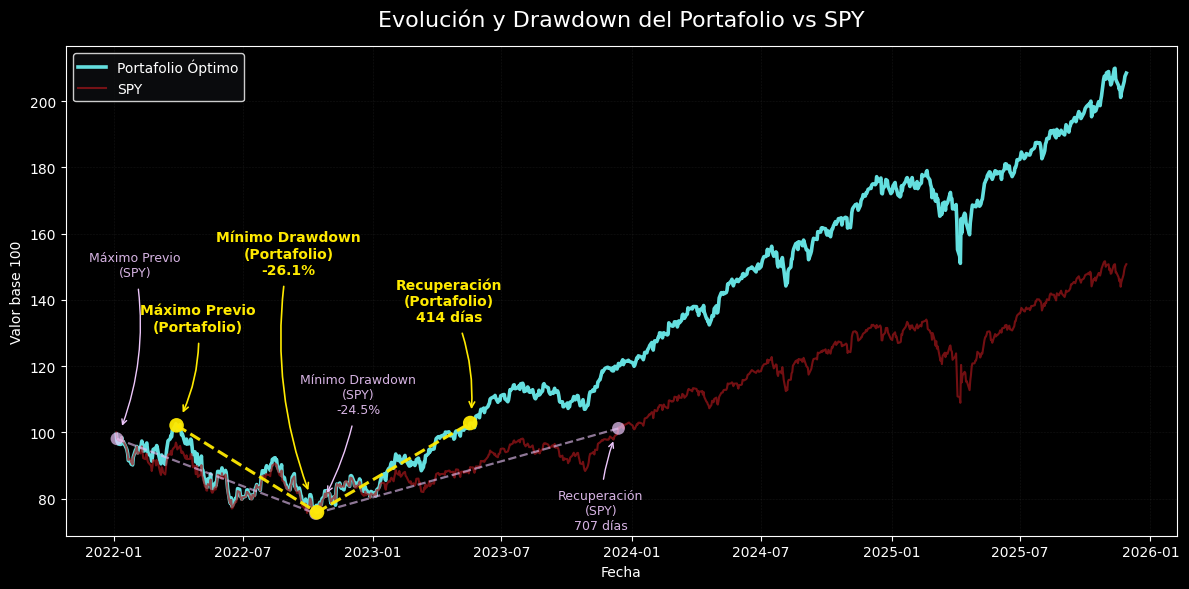

In [67]:
# Paso 31: Visualización del Drawdown y recuperación

if 'ep_port' not in locals():
    ep_port = drawdown_episodes(evol_port)
if 'ep_spy' not in locals():
    ep_spy  = drawdown_episodes(evol_spy)

worst_port = ep_port.loc[ep_port['depth_pct'].idxmin()]
worst_spy  = ep_spy.loc[ep_spy['depth_pct'].idxmin()]

f_ini_port = pd.to_datetime(worst_port['peak_date'])
f_min_port = pd.to_datetime(worst_port['trough_date'])
f_rec_port = pd.to_datetime(worst_port['recovery_date']) if pd.notna(worst_port['recovery_date']) else None
ddmax_port = worst_port['depth_pct']

f_ini_spy = pd.to_datetime(worst_spy['peak_date'])
f_min_spy = pd.to_datetime(worst_spy['trough_date'])
f_rec_spy = pd.to_datetime(worst_spy['recovery_date']) if pd.notna(worst_spy['recovery_date']) else None
ddmax_spy = worst_spy['depth_pct']


dias_rec_port = int(worst_port["total_days"]) if pd.notna(worst_port["total_days"]) else None
dias_rec_spy  = int(worst_spy["total_days"])  if pd.notna(worst_spy["total_days"])  else None

plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(evol_port, color="#64dfdf", lw=2.6, label="Portafolio Óptimo")
ax.plot(evol_spy,  color="#a4161a", lw=1.5, alpha=0.7, label="SPY")

ax.scatter([f_ini_port, f_min_port], evol_port.loc[[f_ini_port, f_min_port]],
           s=110, facecolor="#ffea00", edgecolor='none', alpha=0.95, zorder=6)
if f_rec_port:
    ax.scatter(f_rec_port, evol_port.loc[f_rec_port],
               s=110, facecolor="#ffea00", edgecolor='none', alpha=0.95, zorder=6)

ax.plot([f_ini_port, f_min_port], evol_port.loc[[f_ini_port, f_min_port]],
        color="#ffea00", linestyle="--", lw=2.2, alpha=0.95)
if f_rec_port:
    ax.plot([f_min_port, f_rec_port], evol_port.loc[[f_min_port, f_rec_port]],
            color="#ffea00", linestyle="--", lw=2.2, alpha=0.95)

ax.annotate("Máximo Previo\n(Portafolio)",
            xy=(f_ini_port, evol_port.loc[f_ini_port]),
            xytext=(f_ini_port + pd.Timedelta(days=30),
                    evol_port.loc[f_ini_port]*1.28),
            ha="center", color="#ffea00", fontsize=10, fontweight="bold",
            arrowprops=dict(arrowstyle="->", color="#ffea00", lw=1.2,
                            shrinkA=5, shrinkB=10, connectionstyle="arc3,rad=-0.15"))

ax.annotate(f"Mínimo Drawdown\n(Portafolio)\n{ddmax_port:.1f}%",
            xy=(f_min_port, evol_port.loc[f_min_port]),
            xytext=(f_min_port - pd.Timedelta(days=40),
                    evol_port.loc[f_min_port]*1.95),
            ha="center", color="#ffea00", fontsize=10, fontweight="bold",
            arrowprops=dict(arrowstyle="->", color="#ffea00", lw=1.2,
                            shrinkA=5, shrinkB=17, connectionstyle="arc3,rad=0.15"))

if f_rec_port:
    ax.annotate(f"Recuperación\n(Portafolio)\n{dias_rec_port} días",
                xy=(f_rec_port, evol_port.loc[f_rec_port]),
                xytext=(f_rec_port - pd.Timedelta(days=30),
                        evol_port.loc[f_rec_port]*1.30),
                ha="center", color="#ffea00", fontsize=10, fontweight="bold",
                arrowprops=dict(arrowstyle="->", color="#ffea00", lw=1.2,
                                shrinkA=5, shrinkB=10, connectionstyle="arc3,rad=-0.15"))

ax.scatter([f_ini_spy, f_min_spy], evol_spy.loc[[f_ini_spy, f_min_spy]],
           s=85, facecolor="#eec7fc", edgecolor='none', alpha=0.7, zorder=5)
if f_rec_spy:
    ax.scatter(f_rec_spy, evol_spy.loc[f_rec_spy],
               s=85, facecolor="#eec7fc", edgecolor='none', alpha=0.7, zorder=5)

ax.plot([f_ini_spy, f_min_spy], evol_spy.loc[[f_ini_spy, f_min_spy]],
        color="#eec7fc", linestyle="--", lw=1.6, alpha=0.6)
if f_rec_spy:
    ax.plot([f_min_spy, f_rec_spy], evol_spy.loc[[f_min_spy, f_rec_spy]],
            color="#eec7fc", linestyle="--", lw=1.6, alpha=0.6)

ax.annotate("Máximo Previo\n(SPY)",
            xy=(f_ini_spy, evol_spy.loc[f_ini_spy]),
            xytext=(f_ini_spy + pd.Timedelta(days=25),
                    evol_spy.loc[f_ini_spy]*1.5),
            ha="center", color="#eec7fc", fontsize=9, alpha=0.9,
            arrowprops=dict(arrowstyle="->", color="#eec7fc", lw=1.0,
                            shrinkA=5, shrinkB=10, connectionstyle="arc3,rad=-0.15"))

ax.annotate(f"Mínimo Drawdown\n(SPY)\n{ddmax_spy:.1f}%",
            xy=(f_min_spy, evol_spy.loc[f_min_spy]),
            xytext=(f_min_spy + pd.Timedelta(days=60),
                    evol_spy.loc[f_min_spy]*1.40),
            ha="center", color="#eec7fc", fontsize=9, alpha=0.9,
            arrowprops=dict(arrowstyle="->", color="#eec7fc", lw=1.0,
                            shrinkA=5, shrinkB=17, connectionstyle="arc3,rad=-0.1"))

if f_rec_spy:
    ax.annotate(f"Recuperación\n(SPY)\n{dias_rec_spy} días",
                xy=(f_rec_spy, evol_spy.loc[f_rec_spy]),
                xytext=(f_rec_spy - pd.Timedelta(days=25),
                        evol_spy.loc[f_rec_spy]*0.7),
                ha="center", color="#eec7fc", fontsize=9, alpha=0.9,
                arrowprops=dict(arrowstyle="->", color="#eec7fc", lw=1.0,
                                shrinkA=5, shrinkB=10, connectionstyle="arc3,rad=-0.1"))

ax.set_title("Evolución y Drawdown del Portafolio vs SPY", fontsize=16, color="white", pad=14)
ax.set_xlabel("Fecha", color="white"); ax.set_ylabel("Valor base 100", color="white")
ax.legend(facecolor="#0D0F11", edgecolor="white", loc="upper left")
ax.grid(alpha=0.15, lw=0.4, linestyle=":")
for s in ax.spines.values(): s.set_color("white")
plt.subplots_adjust(top=0.85, bottom=0.12, left=0.08, right=0.98)
plt.tight_layout(); plt.show()



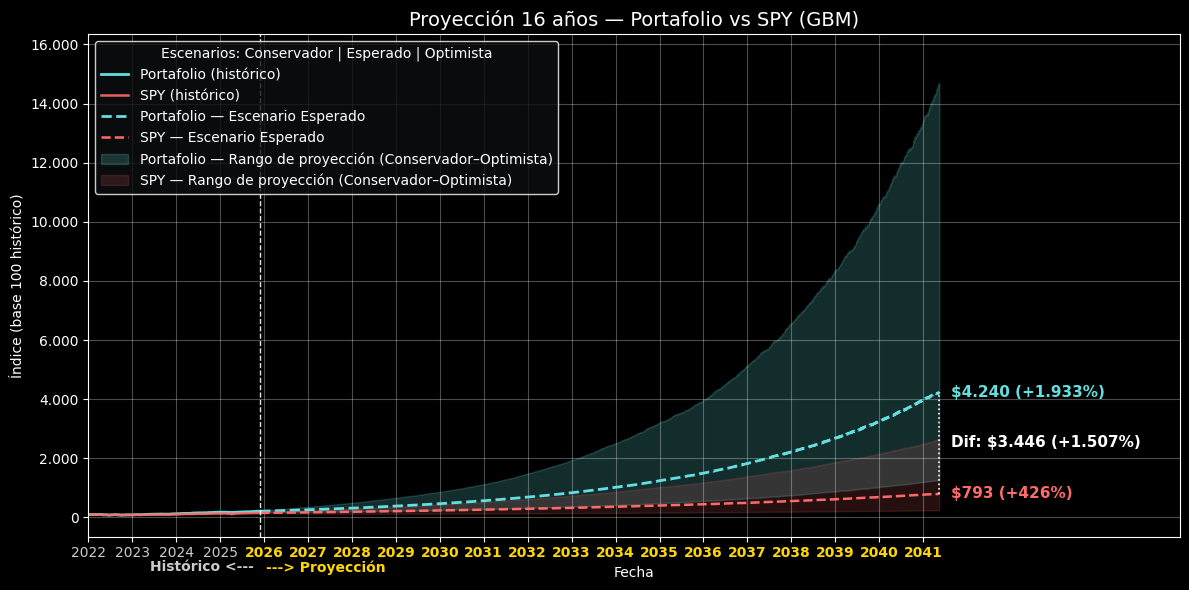

In [68]:
# Paso 32: Proyección a 16 años — Escenarios Conservador, Esperado y Optimista

YEARS = 16
DAYS  = int(252 * YEARS)
N_PATHS = 10_000
np.random.seed(42)

# Función GBM
def simulate_gbm_paths(S0, mu_ann, sigma_ann, days, n_paths=10_000):
    dt = 1/252
    drift = (mu_ann - 0.5 * sigma_ann**2) * dt
    vol   = sigma_ann * np.sqrt(dt)
    Z = np.random.normal(size=(days, n_paths))
    log_ret = drift + vol * Z
    paths = S0 * np.exp(np.cumsum(log_ret, axis=0))
    return paths

def summarize_percentiles(paths, probs=(5,50,95)):
    q = np.percentile(paths, probs, axis=1).T
    df = pd.DataFrame(q, columns=[f"P{p}" for p in probs])
    return df

# Alinear retornos diarios históricos para estimar
ret_spy_aligned  = ret_diarios_all["SPY"].dropna()
ret_port_aligned = ret_port_opt.reindex(ret_spy_aligned.index).dropna()
idx = ret_spy_aligned.index.intersection(ret_port_aligned.index)
ret_spy_aligned  = ret_spy_aligned.loc[idx]
ret_port_aligned = ret_port_aligned.loc[idx]

# Estimadores ANUALES
mu_port  = ret_port_aligned.mean() * 252
sig_port = ret_port_aligned.std()  * np.sqrt(252)
mu_spy   = ret_spy_aligned.mean() * 252
sig_spy  = ret_spy_aligned.std()  * np.sqrt(252)

# Valores iniciales (último histórico)
S0_port = float(evol_port.iloc[-1])
S0_spy  = float(evol_spy.iloc[-1])

# Simular GBM
gbm_port = simulate_gbm_paths(S0_port, mu_port, sig_port, DAYS, n_paths=N_PATHS)
gbm_spy  = simulate_gbm_paths(S0_spy,  mu_spy,  sig_spy,  DAYS, n_paths=N_PATHS)

bands_gbm_port = summarize_percentiles(gbm_port, probs=(5,50,95))
bands_gbm_spy  = summarize_percentiles(gbm_spy,  probs=(5,50,95))

# Índice temporal futuro (solo días hábiles)
future_index = pd.bdate_range(start=evol_port.index[-1] + pd.Timedelta(days=1), periods=DAYS)

# Asegurar misma longitud
m = min(len(future_index), len(bands_gbm_port), len(bands_gbm_spy))
bands_gbm_port = bands_gbm_port.iloc[:m].copy()
bands_gbm_spy  = bands_gbm_spy.iloc[:m].copy()
future_index   = future_index[:m]
bands_gbm_port.index = future_index
bands_gbm_spy.index  = future_index

# Gráfico con división 'Histórico | Proyección' + etiquetas finales ($ y %)
plt.style.use("dark_background")

# Presentación
extra_days          = 2000   # ancho extra a la derecha
label_offset        = 0.05   # posición horizontal de las etiquetas dentro del margen
YEAR_PROJECTION_IN  = 2026   # desde qué año pintar en amarillo
SHOW_VALUE_LABELS   = True   # mostrar montos ($)
SHOW_PERCENT_LABELS = True   # mostrar % desde hoy hasta el final
CURRENCY_SYMBOL     = "$"    # símbolo de moneda

# Etiquetas para los percentiles
LAB_P5   = "Escenario Conservador"
LAB_P50  = "Escenario Esperado"
LAB_P95  = "Escenario Optimista"
LAB_BAND = "Rango de proyección (Conservador–Optimista)"

fig, ax = plt.subplots(figsize=(12,6))

# Histórico
ax.plot(evol_port.index, evol_port.values, color="#64dfdf", lw=2.0, label="Portafolio (histórico)")
ax.plot(evol_spy.index,  evol_spy.values,  color="#ff6b6b", lw=1.8, alpha=0.9, label="SPY (histórico)")

# Proyección (GBM)
ax.plot(bands_gbm_port.index, bands_gbm_port["P50"], color="#64dfdf", lw=2.0, ls="--",
        label=f"Portafolio — {LAB_P50}")
ax.plot(bands_gbm_spy.index,  bands_gbm_spy["P50"],  color="#ff6b6b", lw=1.8, ls="--",
        label=f"SPY — {LAB_P50}")

ax.fill_between(bands_gbm_port.index, bands_gbm_port["P5"], bands_gbm_port["P95"],
                color="#64dfdf", alpha=0.20, label=f"Portafolio — {LAB_BAND}")
ax.fill_between(bands_gbm_spy.index,  bands_gbm_spy["P5"],  bands_gbm_spy["P95"],
                color="#ff6b6b", alpha=0.15, label=f"SPY — {LAB_BAND}")

# Línea divisoria (inicio proyección)
fecha_div = evol_port.index[-1]
ax.axvline(fecha_div, color="white", linestyle="--", lw=1.0, alpha=0.9)

# Texto inferior
y_text = ax.get_ylim()[0] - (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.05
ax.text(fecha_div - pd.Timedelta(days=50), y_text, "Histórico <---",
        color="#cccccc", fontsize=10, ha="right", va="top", fontweight="bold")
ax.text(fecha_div + pd.Timedelta(days=50), y_text, "---> Proyección",
        color="#FFD700", fontsize=10, ha="left", va="top", fontweight="bold")

# Título y estilo general
ax.set_title("Proyección 16 años — Portafolio vs SPY (GBM)", fontsize=14)
ax.set_xlabel("Fecha", color="white")
ax.set_ylabel("Índice (base 100 histórico)", color="white")
ax.grid(alpha=0.3)
leg = ax.legend(loc="upper left", frameon=True, facecolor="#0d0f11", edgecolor="white")
leg.set_title("Escenarios: Conservador | Esperado | Optimista")

# Espacio extra a la derecha para que entren las etiquetas finales
ax.set_xlim(evol_port.index[0], bands_gbm_port.index[-1] + pd.Timedelta(days=extra_days))

for s in ax.spines.values():
    s.set_color("white")
ax.tick_params(colors="white")

# Eje X
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter  # ← import para formatear eje Y

start_year    = evol_port.index[0].year
end_proj_year = bands_gbm_port.index[-1].year
ticks = pd.date_range(pd.Timestamp(start_year, 1, 1),
                      pd.Timestamp(end_proj_year, 12, 31),
                      freq="YS")
ax.set_xticks(ticks)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.canvas.draw()

for lab in ax.get_xticklabels():
    txt = lab.get_text()
    if txt.isdigit() and int(txt) >= YEAR_PROJECTION_IN:
        lab.set_color('#FFD700')
        lab.set_fontweight('bold')
    else:
        lab.set_color('#cccccc')

# Formateo eje Y con separador de miles
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}".replace(",", "_").replace(".", ",").replace("_", ".")))

# Etiquetas finales ($ y %)
x_text = bands_gbm_port.index[-1] + pd.Timedelta(days=int(extra_days * label_offset))
base_port_hoy = evol_port.iloc[-1]
base_spy_hoy  = evol_spy.iloc[-1]
final_port = float(bands_gbm_port["P50"].iloc[-1])
final_spy  = float(bands_gbm_spy["P50"].iloc[-1])
ret_port_pct = (final_port / base_port_hoy - 1) * 100.0
ret_spy_pct  = (final_spy  / base_spy_hoy  - 1) * 100.0
diff_pct     = ret_port_pct - ret_spy_pct
diff_value   = final_port - final_spy

ymin, ymax   = ax.get_ylim()
ax.set_ylim(ymin, max(ymax, final_port, final_spy) * 1.06)

# Función de formato sin decimales
def fmt_value_and_pct(val, pct, show_val=True, show_pct=True, curr="$"):
    parts = []
    if show_val:
        formatted_val = f"{val:,.0f}".replace(",", "_").replace(".", ",").replace("_", ".")
        parts.append(f"{curr}{formatted_val}")
    if show_pct:
        formatted_pct = f"{pct:+,.0f}".replace(",", "_").replace(".", ",").replace("_", ".")
        parts.append(f"({formatted_pct}%)")
    return " ".join(parts)

ax.text(x_text, final_port, fmt_value_and_pct(final_port, ret_port_pct,
        SHOW_VALUE_LABELS, SHOW_PERCENT_LABELS, CURRENCY_SYMBOL),
        color="#64dfdf", fontsize=11, va="center", ha="left",
        fontweight="bold", clip_on=False)

ax.text(x_text, final_spy, fmt_value_and_pct(final_spy, ret_spy_pct,
        SHOW_VALUE_LABELS, SHOW_PERCENT_LABELS, CURRENCY_SYMBOL),
        color="#ff6b6b", fontsize=11, va="center", ha="left",
        fontweight="bold", clip_on=False)

ax.vlines(bands_gbm_port.index[-1], ymin=min(final_port, final_spy), ymax=max(final_port, final_spy),
          colors="white", linestyles="dotted", linewidth=1.2)

dif_text = []
if SHOW_VALUE_LABELS:
    formatted_diff_value = f"{diff_value:,.0f}".replace(",", "_").replace(".", ",").replace("_", ".")
    dif_text.append(f"Dif: {CURRENCY_SYMBOL}{formatted_diff_value}")
if SHOW_PERCENT_LABELS:
    formatted_diff_pct = f"{diff_pct:+,.0f}".replace(",", "_").replace(".", ",").replace("_", ".")
    dif_text.append(f"({formatted_diff_pct}%)")

ax.text(x_text, (final_port + final_spy)/2, " ".join(dif_text),
        color="white", fontsize=11, fontweight="bold", va="center", ha="left",
        bbox=dict(fc=(0,0,0,0.4), ec="none", boxstyle="round,pad=0.3"),
        clip_on=False)

plt.tight_layout()
plt.show()

